# Starbucks Capstone Challenge

### Prject Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Problem statement

The major objective of this jupyter notebook is to analyze the data sets provided by Udacity/Starbucks. We want to learn from the data if we can predict based on demographic data if a person is willing to complete an offer, i.e. if he is willing to make a purchase at Starbucks if he/she is given an offer. 

In the following we plan to answer the following questions:
- What are the persona cluster among the customers in the data set?
- Can we in general predict if a customer takes an offer and to which offer (bogo or discount) he/she is more responsive?
- Which characteristica do have the most common influence on the prediction?

### Strategy

In order to achieve this we apply Crisp-DM (Cross Industry Standard Process for Data Mining) in the following. This involves the following steps: 

- Business Understanding - we have raised the three key questions above about the Starbucks data set
- Data Understanding - we have explored the three test sets provided by Starbucks/Udacity
- Data Preparation - we have cleaned the data by dropping features, by imputing values, and by converting categorical into numerical data from the original data set
- Modelling - we have modelled the classification and prediction questions with a KMeans classifier and a random forest classifier 
- Evaluation - we have evaluated the resuling models. For the KMeans classifier, we have used the Silhouette score, for the random forest classifier, we have used the accuracy score
- Deployment - we have discussed the findings as a final report in a medium blog post 

The modelling step is twofold:
- For the clusering of the customers into personas, we employ a Kmeans algorithm. This is a common approach to clustering problems. In order to find the number of clusters, we apply a hyperparameter tuning approach
- For the prediction of the willingness of a customer to take an offer, we employ a RandomForestClassifier, where we apploy a hyperparameter tuning approach to find optimal parameters.

#### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


### Metrics for Validation

In order to validate the model we use the following metrics:

#### Silhouette score
For the kmeans algorithm we employ a silhouette score. A silhouette score is useful in this case since we don't have labeled data for our data set. The higher the score the more does the model relate to better defined clusters. This is an inituitive explanation behin clusters.

More information on the silhouette score can be found at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

#### Accuracy score
For a classification algorithm the accuracy score is the most intuitive score. It gives the percentage of the set of prediceted labels for a sample exactly matching the set of actual labels.

More information on the accurarcy score can be found at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



### Table of Contents

* [Importing Libraries and reading data sets](#chapter1)
* [Data Exploration and Visualization](#chapter2)
* [Data Cleaning and Preprocessing](#chapter3)
    * [Portfolio Data Set](#chapter3_1)
        * [Cleaning](#chapter3_1_1)
        * [Visualization](#chapter3_1_2)
    * [Profile Data Set](#chapter3_2)
        * [Cleaning](#chapter3_2_1)
        * [Visualization](#chapter3_2_2)
    * [Transcript Data Set](#chapter3_3)
        * [Cleaning](#chapter3_3_1)
        * [Visualization](#chapter3_3_2)
* [Model Building and Evaluation and Validation](#chapter4)
    * [Clustering into personas](#chapter_4_1)
        * [Model implementation](#chapter_4_1_1)
        * [Evaluation and validation](#chapter_4_1_2)
    * [Predicting if customer takes offer](#chapter_4_2)
        * [Model implementation](#chapter_4_2_1)
        * [Evaluation and validation](#chapter_4_2_2)
* [Conclusion](#chapter5)
    * [Reflection](#chapter_5_1)
    * [Improvement](#chapter_5_2)



### Importing Libraries and reading data sets <a class="anchor" id="chapter1"></a>

Here, we import the necesary python libraries and read the datasets (portfolio, profile, and transcript). In addition, we set some optionas for matplotlib and pandas.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option("display.max_columns", 200)

# read in the json files
portfolio = pd.read_json("data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("data/profile.json", orient="records", lines=True)
transcript = pd.read_json("data/transcript.json", orient="records", lines=True)

num_fig = 1

### Data Exploration and Visualization <a class="anchor" id="chapter2"></a>

In the following section, we explore the the data. We inspect the content of the datasets and get the ratio of missing values in each column. 

We do this in the following order 
- portfolio
- profile
- transcript

In [2]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [3]:
# Missing values
print(f"Portfolio shape {portfolio.shape}")
portfolio_info = pd.DataFrame(portfolio.dtypes).T.rename(index={0: "Data Type"})
portfolio_info = portfolio_info.append(
    pd.DataFrame(portfolio.isnull().sum() / portfolio.shape[0] * 100).T.rename(
        index={0: "Missing values in %"}
    )
)
portfolio_info

Portfolio shape (10, 6)


reward channels difficulty duration offer_type      id
Data Type            int64   object      int64    int64     object  object
Missing values in %    0.0      0.0        0.0      0.0        0.0     0.0

In [4]:
profile

gender  age                                id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [5]:
# Missing values
print(f"Profile shape {profile.shape}")
profile_info = pd.DataFrame(profile.dtypes).T.rename(index={0: "Data Type"})
profile_info = profile_info.append(
    pd.DataFrame(profile.isnull().sum() / profile.shape[0] * 100).T.rename(
        index={0: "Missing values in %"}
    )
)
profile_info

Profile shape (17000, 5)


gender    age      id became_member_on     income
Data Type               object  int64  object            int64    float64
Missing values in %  12.794118    0.0     0.0              0.0  12.794118

In [6]:
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
...                                                  ...   ...  
306529                    {'amount': 1.5899999999999999}   714  
306530                                  {'amount': 9.53}   714  
306531                                  {'amount': 3.61}   714  
306532                    {'amount': 3.5300000000000002}   714  
306533                                  {'amount': 4.05}   714  

[306534 rows x 4 columns]

In [7]:
# Missing values
print(f"Transcript shape {transcript.shape}")
transcript_info = pd.DataFrame(transcript.dtypes).T.rename(index={0: "Data Type"})
transcript_info = transcript_info.append(
    pd.DataFrame(transcript.isnull().sum() / transcript.shape[0] * 100).T.rename(
        index={0: "Missing values in %"}
    )
)
transcript_info

Transcript shape (306534, 4)


person   event   value   time
Data Type            object  object  object  int64
Missing values in %     0.0     0.0     0.0    0.0

### Data Cleaning and Preprocessing <a class="anchor" id="chapter3"></a>

In this section we start to clean the data. Data cleaning consists of dropping features, of imputing values, and of converting categorical into numerical data from the original data set. We do this for each data set separately.

#### Portfolio Data Set  <a class="anchor" id="chapter3_1"></a>

The portfolio data set contains offer ids and meta data about each offer (duration, type, etc.). 

##### Cleaning  <a class="anchor" id="chapter3_1_1"></a>

We clean the portfolio data set as follows: the channels and the offer_type are converted from categorical data into numerical data. Furthermore, we rename `ìd`and `reward` into `offer_id` and `portfolio_reward`, respectively in order to avoid ambiguity since those names are also part of the other data sets.

In [8]:
def clean_portfolio(df):
    """
    input:
        df: raw portfolio data set
    output:
        df_clean: cleaned portfolio data set
    """

    # One hot encoding for channels and offer_type
    df_clean = df.copy()
    channels = pd.get_dummies(
        df_clean.channels.apply(pd.Series).stack(), prefix="channel"
    ).sum(level=0)
    df_clean = df_clean.drop(labels="channels", axis=1)
    df_clean = pd.concat([df_clean, channels], axis=1)

    df_clean = pd.get_dummies(df_clean, columns=["offer_type"], prefix="offer_type")
    
    # Rename id and rewards
    df_clean = df_clean.rename({"id": "offer_id", "reward": "portfolio_reward"}, axis=1)

    return df_clean


portfolio_cleaned = clean_portfolio(portfolio)
portfolio_cleaned

portfolio_reward  difficulty  duration                          offer_id  \
0                10          10         7  ae264e3637204a6fb9bb56bc8210ddfd   
1                10          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0   
2                 0           0         4  3f207df678b143eea3cee63160fa8bed   
3                 5           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4                 5          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7   
5                 3           7         7  2298d6c36e964ae4a3e7e9706d1fb8c2   
6                 2          10        10  fafdcd668e3743c1bb461111dcafc2a4   
7                 0           0         3  5a8bc65990b245e5a138643cd4eb9837   
8                 5           5         5  f19421c1d4aa40978ebb69ca19b0e20d   
9                 2          10         7  2906b810c7d4411798c6938adc9daaa5   

   channel_email  channel_mobile  channel_social  channel_web  \
0              1               1               1            0   
1              1               1               1            1   
2              1               1               0            1   
3              1               1               0            1   
4              1               0               0            1   
5              1               1               1            1   
6              1               1               1            1   
7              1               1               1            0   
8              1               1               1            1   
9              1               1               0            1   

   offer_type_bogo  offer_type_discount  offer_type_informational  
0                1                    0                         0  
1                1                    0                         0  
2                0                    0                         1  
3                1                    0                         0  
4                0                    1                         0  
5                0                    1                         0  
6                0                    1                         0  
7                0                    0                         1  
8                1                    0                         0  
9                0                    1                         0

##### Visualization  <a class="anchor" id="chapter3_1_2"></a>

In this section, we visualize the results from the cleaned portfolio data set. This  gives us some more insights into the data.

We start plotting the counts of offer types. Here, we can see that there are four offer types for bogo and discount, while just two are informational.

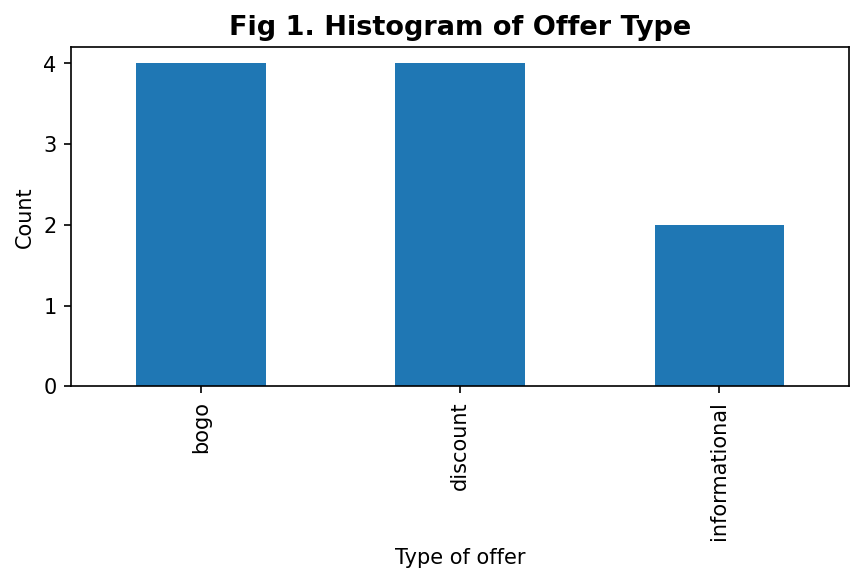

In [9]:
ax = (
    portfolio_cleaned[
        ["offer_type_bogo", "offer_type_discount", "offer_type_informational"]
    ]
    .rename(
        {
            "offer_type_bogo": "bogo",
            "offer_type_discount": "discount",
            "offer_type_informational": "informational",
        },
        axis=1,
    )
    .sum()
    .plot.bar(figsize=(6, 4), legend=False)
)
ax.set_xlabel("Type of offer")
ax.set_ylabel("Count")
ax.set_title(f"Fig {num_fig}. Histogram of Offer Type", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_offer_type")
num_fig = num_fig + 1

We look here at the different channel types. We can clearly see that email is the most often used channel type, while social media is the least often used. 

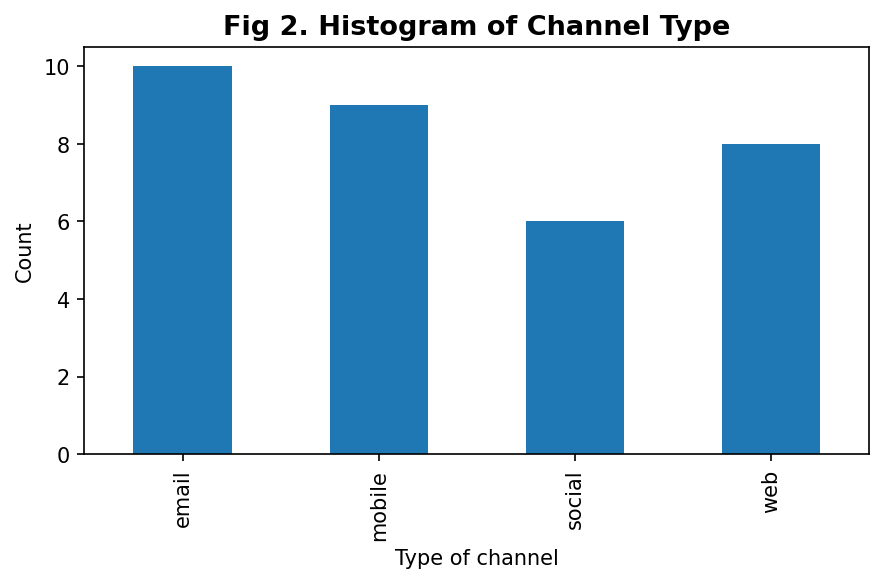

In [10]:
ax = (
    portfolio_cleaned[
        ["channel_email", "channel_mobile", "channel_social", "channel_web"]
    ]
    .rename(
        {
            "channel_email": "email",
            "channel_mobile": "mobile",
            "channel_social": "social",
            "channel_web": "web",
        },
        axis=1,
    )
    .sum()
    .plot.bar(figsize=(6, 4), legend=False)
)
ax.set_xlabel("Type of channel")
ax.set_ylabel("Count")
ax.set_title(f"Fig {num_fig}. Histogram of Channel Type", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_channel_type")
num_fig = num_fig + 1

#### Profile Data Set  <a class="anchor" id="chapter3_2"></a>

The profile data set contains demographic data for each customer such as age, sex, and the tenure of the starbucks membership. This data set gives us deep insights into the customers of Starbucks.

##### Cleaning  <a class="anchor" id="chapter3_2_1"></a>

We clean the profile data set. This is achieved by first converting the became member column dtype to a datetime format. WIth this date we can compute the number of days since a customer is member. Also we rename `ìd` to `customer_id` since `id` is too generic. We add an additional feature to the dataset which states if data is missing. We one-hot-encode the gender and finally fill all missing data with the mean values.

In [11]:
from datetime import datetime


def clean_profile(df):
    """
    input:a
        df: raw profile data set
    output:
        df_clean: cleaned profile data set
    """

    df_clean = df.copy()

    # Transform became_member_on into member_sine_in_days in order to have a numerical value instead of a date.
    df_clean["became_member_on"] = pd.to_datetime(
        df_clean["became_member_on"], format="%Y%m%d"
    )
    df_clean["member_since_in_days"] = (
        df_clean["became_member_on"].max() - df_clean["became_member_on"]
    ).dt.days
    df_clean = df_clean.drop(["became_member_on"], axis=1)
    
    # Renaming
    df_clean = df_clean.rename({"id": "customer_id"}, axis=1)

    # Impute data
    df_clean["age"] = df_clean["age"].replace(118, np.nan)
    df_clean["missing_data"] = df_clean["age"].isnull().astype(int)
    # One hote encoding of gender
    df_clean = pd.get_dummies(df_clean, columns=["gender"], prefix="gender")

    df_clean = df_clean.fillna(df_clean.mean())

    return df_clean


profile_cleaned = clean_profile(profile)
profile_cleaned

age                       customer_id         income  \
0      54.393524  68be06ca386d4c31939f3a4f0e3dd783   65404.991568   
1      55.000000  0610b486422d4921ae7d2bf64640c50b  112000.000000   
2      54.393524  38fe809add3b4fcf9315a9694bb96ff5   65404.991568   
3      75.000000  78afa995795e4d85b5d9ceeca43f5fef  100000.000000   
4      54.393524  a03223e636434f42ac4c3df47e8bac43   65404.991568   
...          ...                               ...            ...   
16995  45.000000  6d5f3a774f3d4714ab0c092238f3a1d7   54000.000000   
16996  61.000000  2cb4f97358b841b9a9773a7aa05a9d77   72000.000000   
16997  49.000000  01d26f638c274aa0b965d24cefe3183f   73000.000000   
16998  83.000000  9dc1421481194dcd9400aec7c9ae6366   50000.000000   
16999  62.000000  e4052622e5ba45a8b96b59aba68cf068   82000.000000   

       member_since_in_days  missing_data  gender_F  gender_M  gender_O  
0                       529             1         0         0         0  
1                       376             0         1         0         0  
2                        14             1         0         0         0  
3                       443             0         1         0         0  
4                       356             1         0         0         0  
...                     ...           ...       ...       ...       ...  
16995                    52             0         1         0         0  
16996                    13             0         0         1         0  
16997                   546             0         0         1         0  
16998                   871             0         1         0         0  
16999                   369             0         1         0         0  

[17000 rows x 8 columns]

##### Visualization  <a class="anchor" id="chapter3_2_2"></a>

We are now ready to visualize the demographic data in our data set. This will help us to obtain a deeper insight into our data.

The histogram of the gender data shows the following. We have more males than females in the data. There is also a notable amount of people which used other as other. Note that other does not denote the member with missing data. 

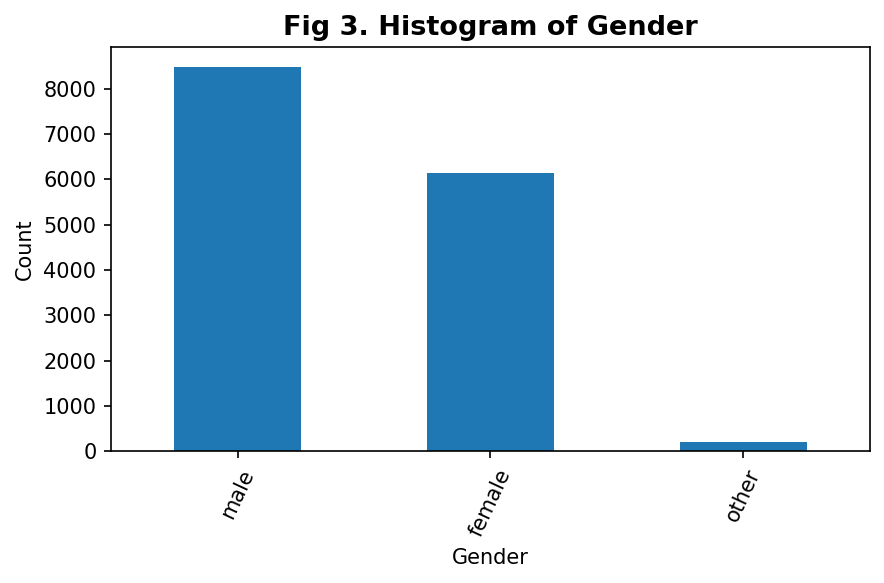

In [12]:
ax = (
    profile[["gender"]]
    .value_counts()
    .rename({"M": "male", "F": "female", "O": "unknown"})
    .plot.bar(figsize=(6, 4), legend=False)
)
ax.set_xticklabels(["male", "female", "other"], rotation=65)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title(f"Fig {num_fig}. Histogram of Gender", fontsize=13, weight="bold")

plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_gender")
num_fig = num_fig + 1

When plotting the `age` column, we can see that the average is a little bit below 60 years old. Note that a lot of people are marked as 118 years. We expect that 118 is used for labeling unkown age. Hence, we dropped this value in the cleaned data frame.

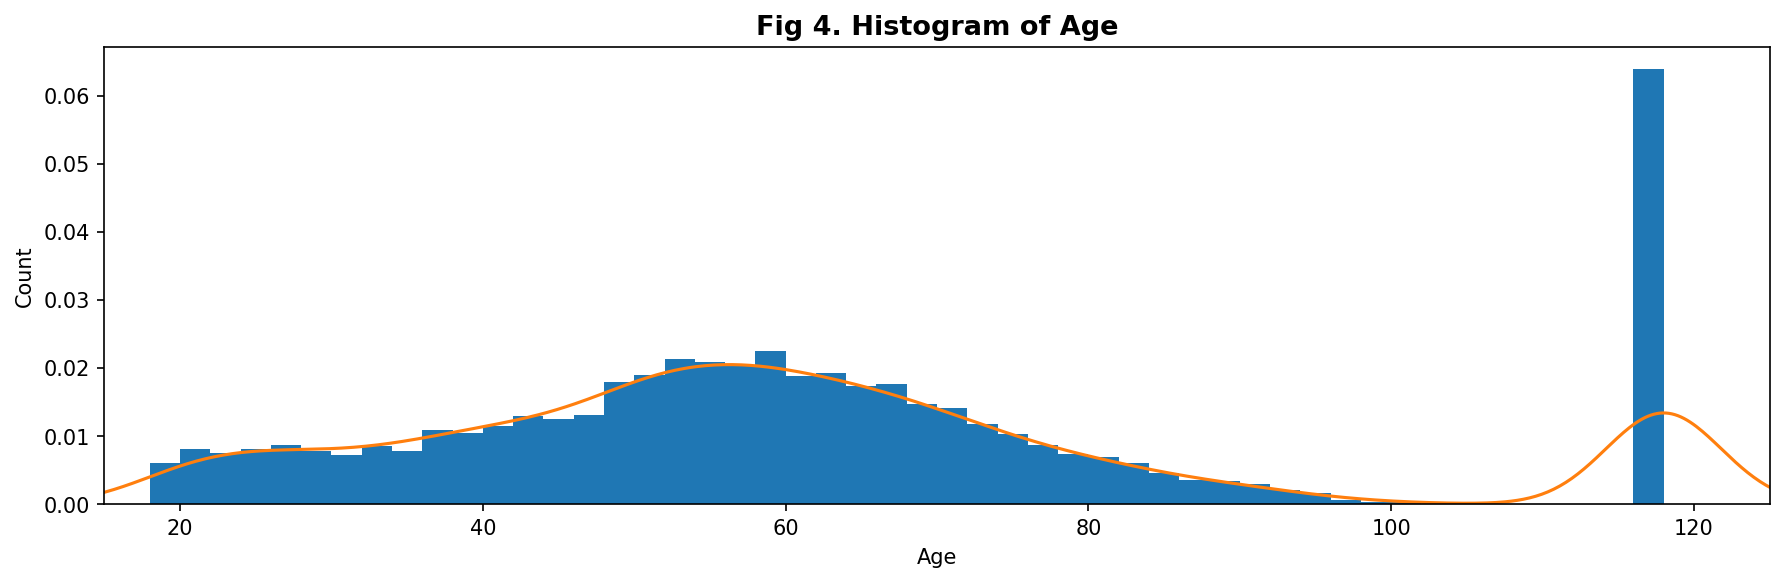

In [13]:
ax = profile[["age"]].plot.hist(
    density=True, figsize=(12, 4), bins=50, xlim=[15, 125], legend=False
)
profile[["age"]].plot.density(ax=ax, legend=False)
ax.set_xlabel("Age")
ax.set_ylabel("Count")

ax.set_title(f"Fig {num_fig}. Histogram of Age", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_age")
num_fig = num_fig + 1

We plot the distribution of the `income` for all users. Note that the average is around 70000. There is little income with more that 100000.

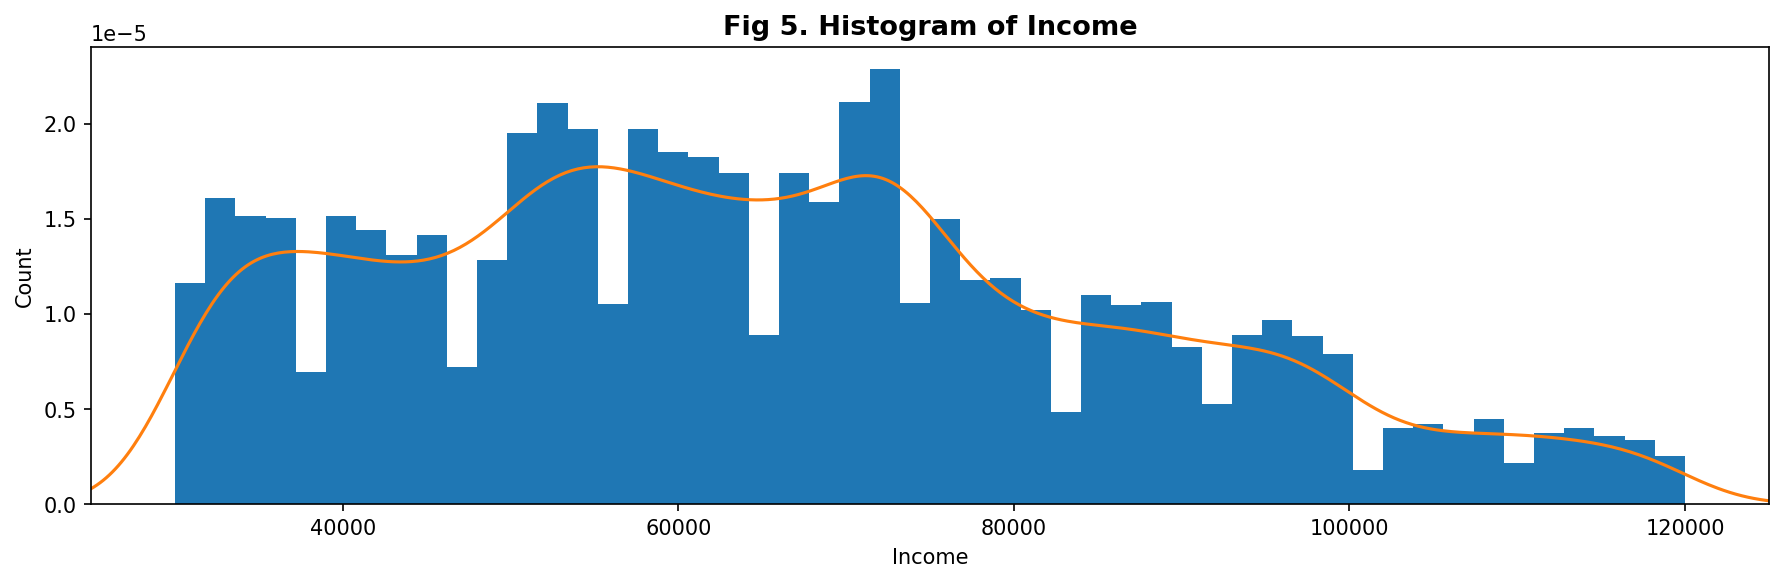

In [14]:
ax = profile[["income"]].plot.hist(
    density=True, figsize=(12, 4), bins=50, xlim=[25000, 125000], legend=False
)
profile[["income"]].plot.density(ax=ax, legend=False)
ax.set_xlabel("Income")
ax.set_ylabel("Count")

ax.set_title(f"Fig {num_fig}. Histogram of Income", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_income")
num_fig = num_fig + 1

The following histogram shows how long a customer is member. This plot is particularly interesting due to two things:

- the eldest member has a tenure of around 1800 days
- there are two edges when a lot of new members became active. One is around 300 days, the other is around 1100 days.

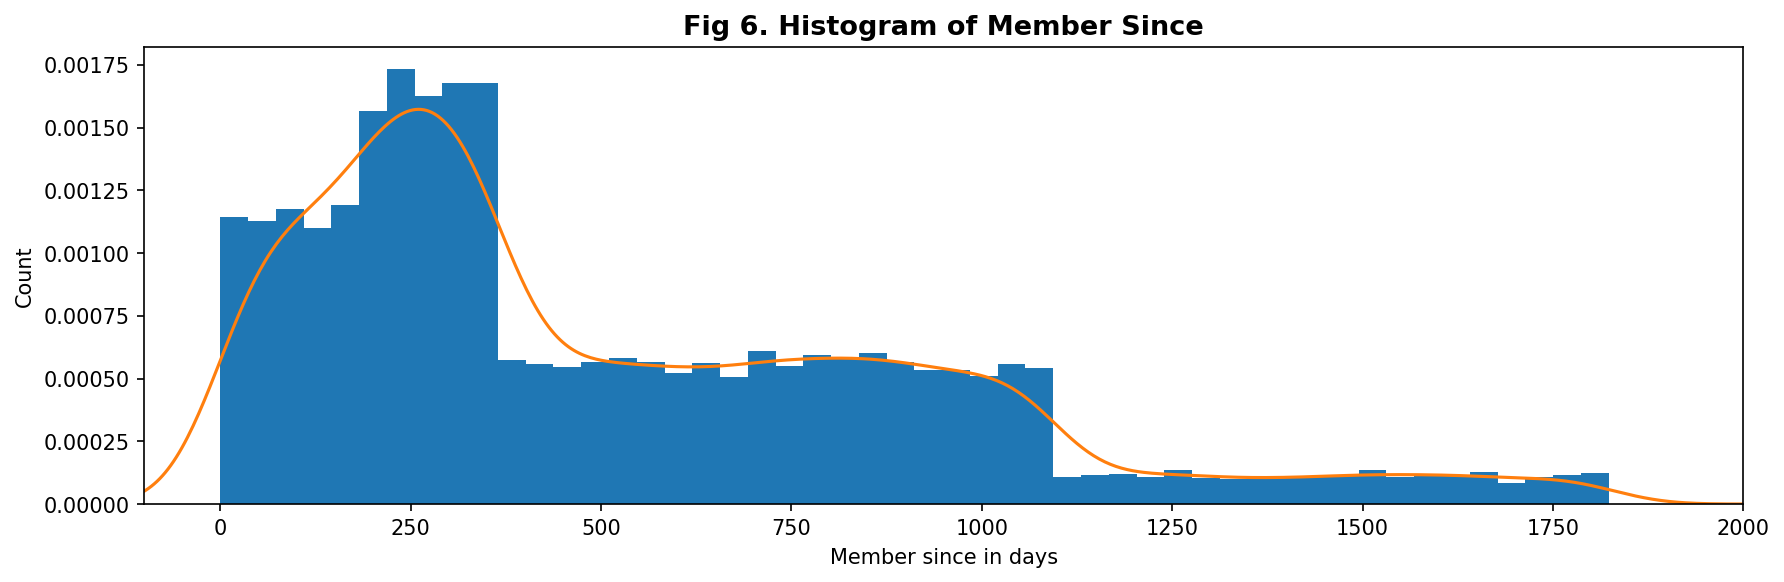

In [15]:
ax = profile_cleaned[["member_since_in_days"]].plot.hist(
    density=True, figsize=(12, 4), bins=50, xlim=[-100, 2000], legend=False
)
profile_cleaned[["member_since_in_days"]].plot.density(ax=ax, legend=False)
ax.set_xlabel("Member since in days")
ax.set_ylabel("Count")

ax.set_title(f"Fig {num_fig}. Histogram of Member Since", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_member_since_in_days")
num_fig = num_fig + 1

The following histogram shows the number of missing data. Missing data means that the customer didn't provide his/her gender, his/her age, and his/her income. We have labeled that data as missing data. We can clearly see in the bar chart that most customerers provided data, but the number of customer with missing data is non-negligible.

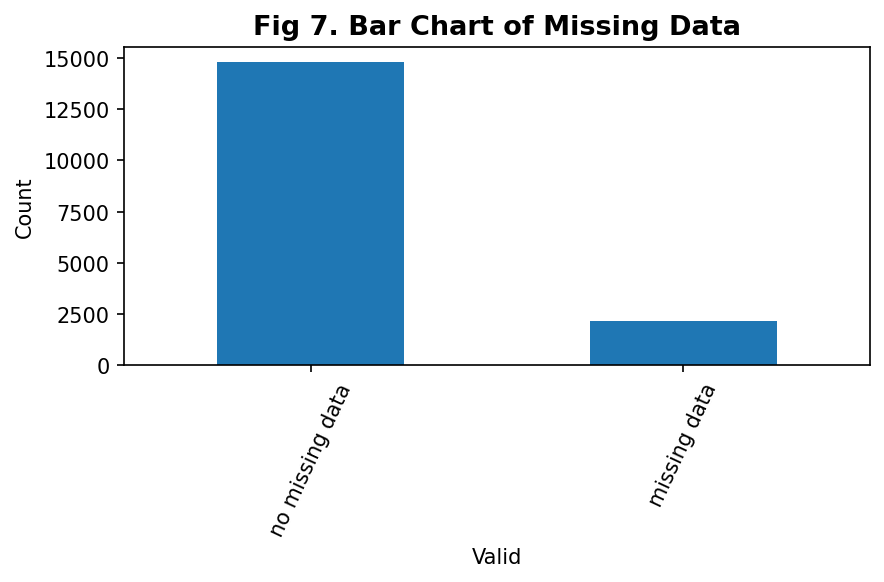

In [16]:
ax = (
    profile_cleaned[["missing_data"]]
    .value_counts()
    .plot.bar(figsize=(6, 4), legend=False)
)
ax.set_xticklabels(["no missing data", "missing data"], rotation=65)
ax.set_xlabel("Valid")
ax.set_ylabel("Count")

ax.set_title(f"Fig {num_fig}. Bar Chart of Missing Data", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_missing_data")
num_fig = num_fig + 1

#### Transcript Data Set  <a class="anchor" id="chapter3_3"></a>

The data set of transcripts keeps the records for transactions, offers received, offers viewed, and offers completed. This is in particlarly interesting since it keeps the reaction of a customer to an offere.

##### Cleaning  <a class="anchor" id="chapter3_3_1"></a>

We clean the data set as follows: the person column is renamed to customer_id since  person is too generic and in order to be aligned with the other data set. Furthere, more we convert the value columns, which is a dict into a series. Hence, we have additaional separate columns for "event_offer_completed", "event_offer_received", "event_offer_viewed", and "transcation":

In [17]:
def clean_transcript(df):
    """
    input:
        df: raw transcript data set
    output:
        df_clean: cleaned transcript data set
    """

    df_clean = df.copy()
    # rename 
    df_clean = df_clean.rename({"person": "customer_id"}, axis=1)

    # convert event to separaete columns
    df_clean = pd.get_dummies(df_clean, columns=["event"], prefix="event")
    values_column = df_clean["value"].apply(pd.Series)
    df_clean = pd.concat([df_clean, values_column], axis=1)

    # fillna fpr amount and reward
    df_clean[["amount", "reward"]] = df_clean[["amount", "reward"]].fillna(
        0, axis=1, downcast="infer"
    )

    # combine offer_id
    df_clean["offer_id"] = df_clean["offer id"].fillna("") + df_clean[
        "offer_id"
    ].fillna("")
    df_clean["offer_id"] = df_clean["offer_id"].replace("", np.nan)

    df_clean = df_clean.drop(labels=["value", "offer id"], axis=1)

    # some more renamings for convenient access
    df_clean = df_clean.rename(
        {
            "event_offer completed": "event_offer_completed",
            "event_offer received": "event_offer_received",
            "event_offer viewed": "event_offer_viewed",
            "reward": "transcript_reward",
        },
        axis=1,
    )

    return df_clean


transcript_cleaned = clean_transcript(transcript)
transcript_cleaned

customer_id  time  event_offer_completed  \
0       78afa995795e4d85b5d9ceeca43f5fef     0                      0   
1       a03223e636434f42ac4c3df47e8bac43     0                      0   
2       e2127556f4f64592b11af22de27a7932     0                      0   
3       8ec6ce2a7e7949b1bf142def7d0e0586     0                      0   
4       68617ca6246f4fbc85e91a2a49552598     0                      0   
...                                  ...   ...                    ...   
306529  b3a1272bc9904337b331bf348c3e8c17   714                      0   
306530  68213b08d99a4ae1b0dcb72aebd9aa35   714                      0   
306531  a00058cf10334a308c68e7631c529907   714                      0   
306532  76ddbd6576844afe811f1a3c0fbb5bec   714                      0   
306533  c02b10e8752c4d8e9b73f918558531f7   714                      0   

        event_offer_received  event_offer_viewed  event_transaction  amount  \
0                          1                   0                  0    0.00   
1                          1                   0                  0    0.00   
2                          1                   0                  0    0.00   
3                          1                   0                  0    0.00   
4                          1                   0                  0    0.00   
...                      ...                 ...                ...     ...   
306529                     0                   0                  1    1.59   
306530                     0                   0                  1    9.53   
306531                     0                   0                  1    3.61   
306532                     0                   0                  1    3.53   
306533                     0                   0                  1    4.05   

                                offer_id  transcript_reward  
0       9b98b8c7a33c4b65b9aebfe6a799e6d9                  0  
1       0b1e1539f2cc45b7b9fa7c272da2e1d7                  0  
2       2906b810c7d4411798c6938adc9daaa5                  0  
3       fafdcd668e3743c1bb461111dcafc2a4                  0  
4       4d5c57ea9a6940dd891ad53e9dbe8da0                  0  
...                                  ...                ...  
306529                               NaN                  0  
306530                               NaN                  0  
306531                               NaN                  0  
306532                               NaN                  0  
306533                               NaN                  0  

[306534 rows x 9 columns]

##### Visualization  <a class="anchor" id="chapter3_3_2"></a>

We are not ready to visualize the insights of the transaction script. This is espescially helpful to later start the modeling of our problem statements.

First we plot the histogram of the transcript rewards. We can see that the rewards are quite discrete, i.e. 2,3, 5, and 10. Most common value is 5.

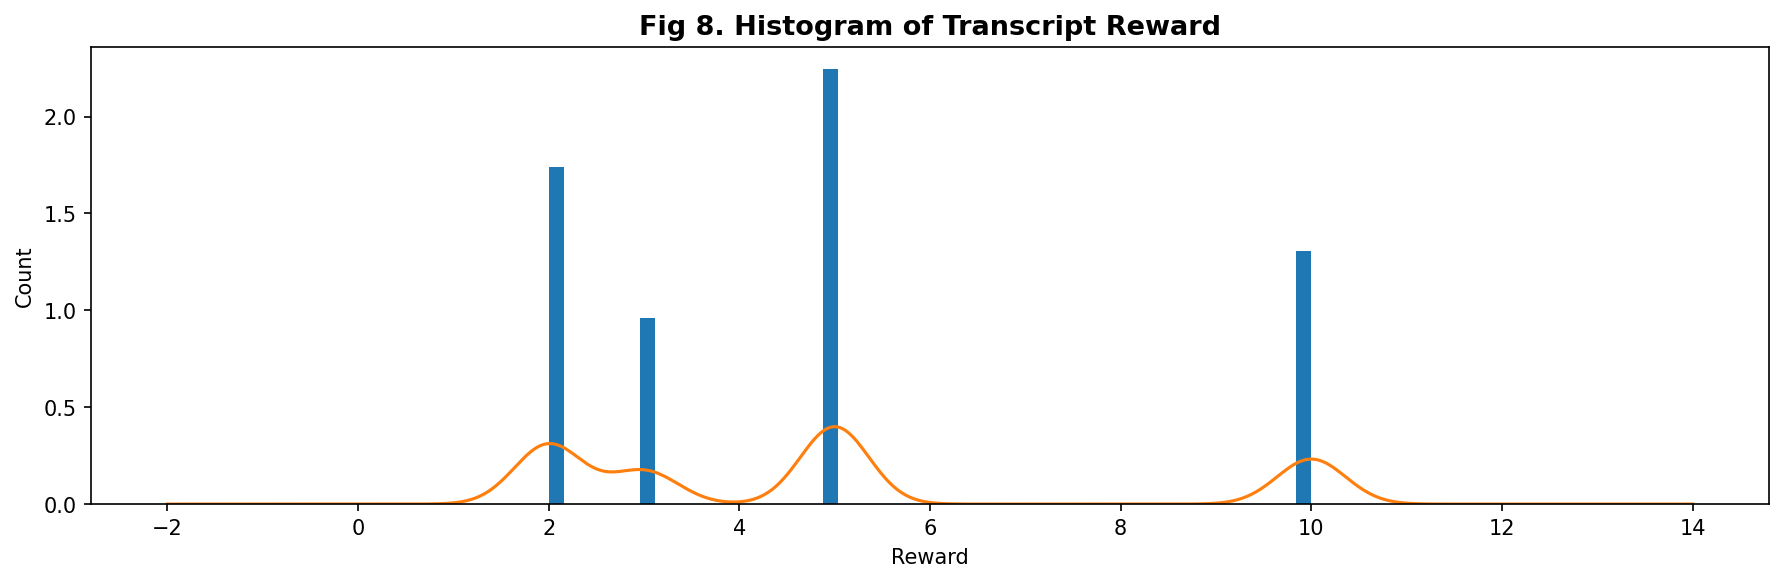

In [18]:
ax = (
    transcript_cleaned["transcript_reward"]
    .replace(0, np.nan)
    .plot.hist(density=True, figsize=(12, 4), bins=50, legend=False)
)
transcript_cleaned["transcript_reward"].replace(0, np.nan).plot.density(
    ax=ax, legend=False
)
ax.set_xlabel("Reward")
ax.set_ylabel("Count")

ax.set_title(
    f"Fig {num_fig}. Histogram of Transcript Reward", fontsize=13, weight="bold"
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_transcript_reward")
num_fig = num_fig + 1

When we plot the amount of money spent in the transaction, we can see that most customer spent money with less that than 5, and no customer spends more money than 50.

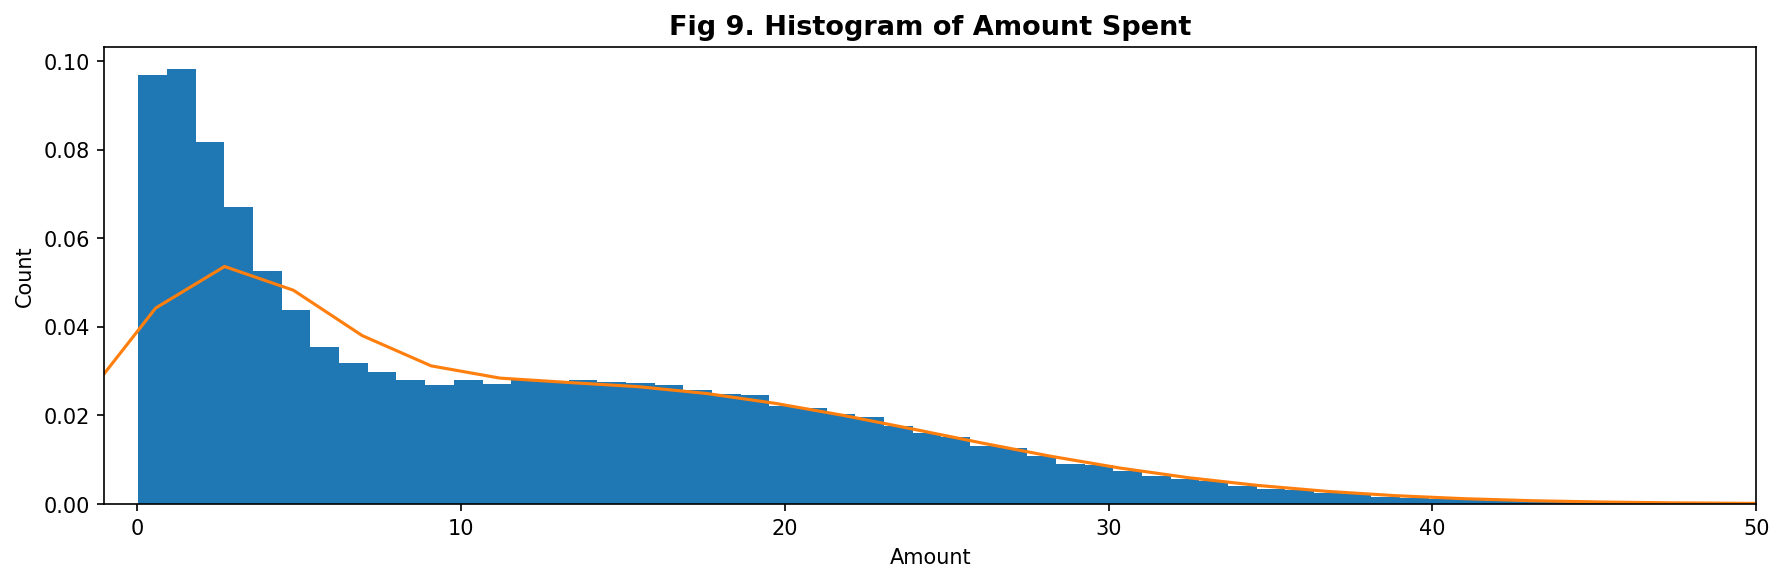

In [19]:
ax = (
    transcript_cleaned["amount"]
    .replace(0, np.nan)
    .plot.hist(density=True, figsize=(12, 4), xlim=[-1, 50], bins=1200, legend=False)
)
transcript_cleaned["amount"].replace(0, np.nan).plot.density(ax=ax, legend=False)
ax.set_xlabel("Amount")
ax.set_ylabel("Count")

ax.set_title(f"Fig {num_fig}. Histogram of Amount Spent", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_amount_spent")
num_fig = num_fig + 1

The time in the transcript as a histogram chart. We cann see that there are 5 peaks, mostly around 150, 330, 400, 500, and 580.

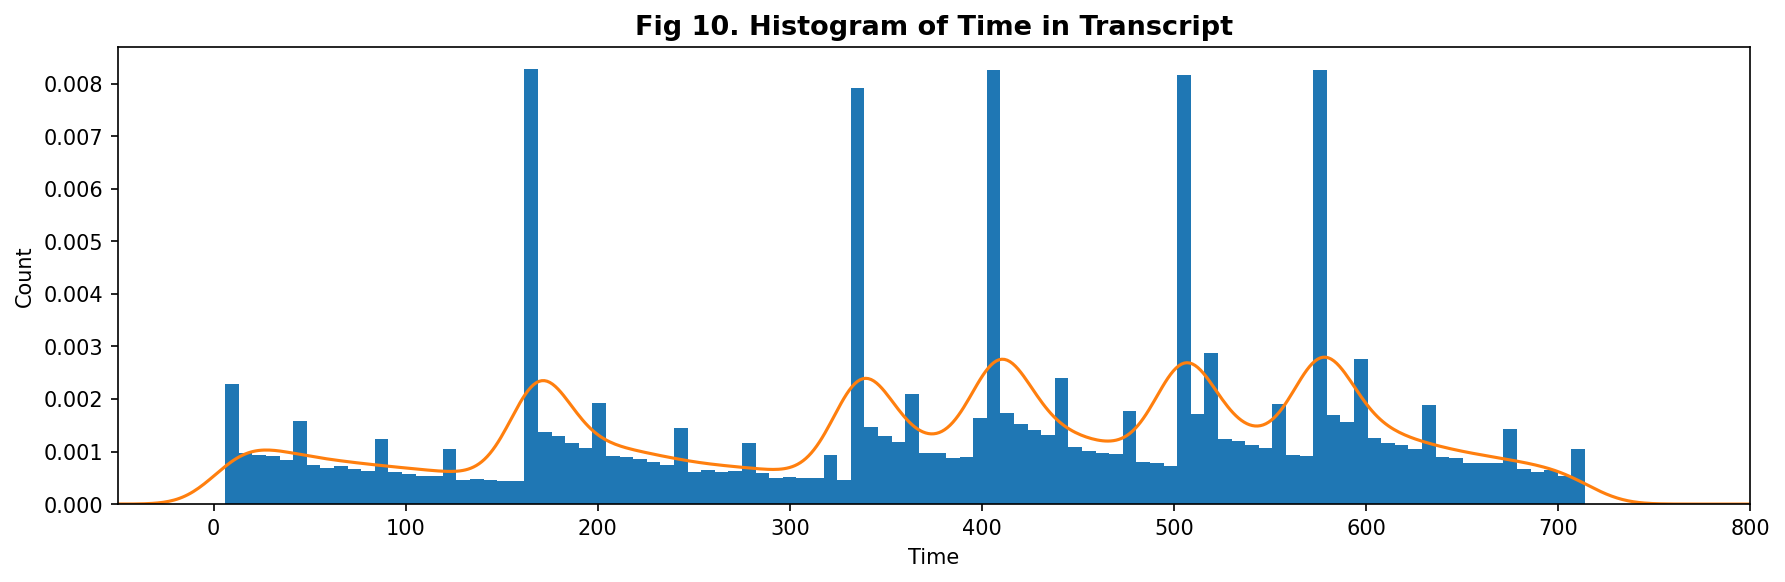

In [20]:
ax = (
    transcript_cleaned["time"]
    .replace(0, np.nan)
    .plot.hist(density=True, figsize=(12, 4), xlim=[-50, 800], bins=100, legend=False)
)
transcript_cleaned["time"].replace(0, np.nan).plot.density(ax=ax, legend=False)
ax.set_xlabel("Time")
ax.set_ylabel("Count")

ax.set_title(
    f"Fig {num_fig}. Histogram of Time in Transcript", fontsize=13, weight="bold"
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_time_in_transcript")
num_fig = num_fig + 1

We plot the occurences of different events in the transcript. We can see that most transaction is the most often occuring event in the transcript data set. Offer received, offer viewed, and offer completed are less common. This is expected since not all customers did receive and offer and for the offer events the sequence must be as follows: first the customer must receive an offer, then he needs to view it and at the end the customer must finally complete the offer. In each of these steps some customer decide not to take the next stage here.

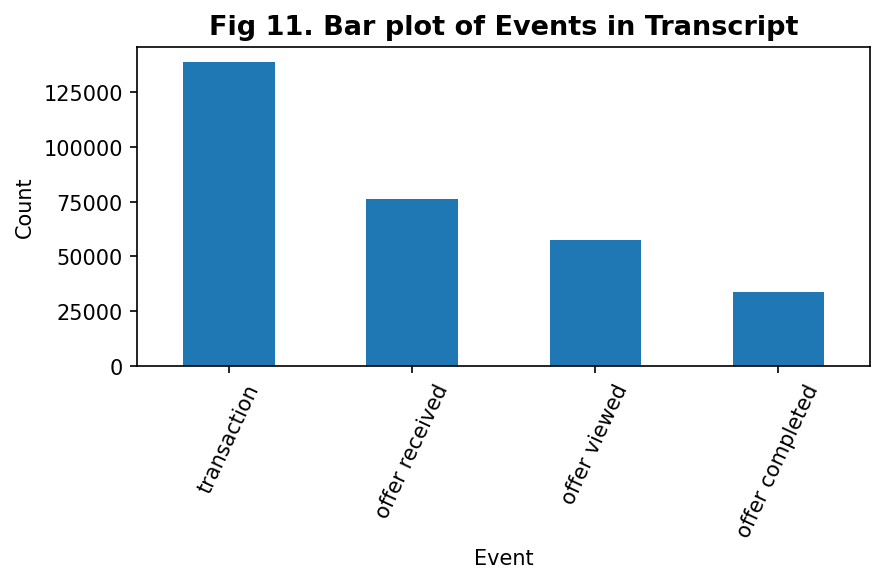

In [21]:
ax = transcript[["event"]].value_counts().plot.bar(figsize=(6, 4), legend=False)
ax.set_xticklabels(
    ["transaction", "offer received", "offer viewed", "offer completed"], rotation=65
)
ax.set_xlabel("Event")
ax.set_ylabel("Count")

ax.set_title(
    f"Fig {num_fig}. Bar plot of Events in Transcript", fontsize=13, weight="bold"
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_transcript_events")
num_fig = num_fig + 1

### Model Building and Evaluation <a class="anchor" id="chapter4"></a>

We are now ready to build the machine learning models. The models are used to cluster and classify the data into groups. The goal of the clustering task is then to group the customers into persona groups based on the demographic data. 
Based on the clustering result we implement a classification pipeline which predicts the willingness of a specific customer to take the offer.

#### Clustering into personas <a class="anchor" id="chapter_4_1"></a>

Our first goal is then to cluster the customers into categories. Here, we use the profile data for it, i.e we use as features the following properties of the customer:
- age
- income
- tenure of membership
- gender
- missing data

We then employ a clustering algorithm based on this subset.

##### Model implementation <a class="anchor" id="chapter_4_1_1"></a>

In order to cluster the customers into groups, we first employ a robust scaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). Robust scalers are robust to outliers and also standardize all the input data. After the data is scaled we employ a Kmeans algorithm. (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) This algorithm groups the  data by finding n subgroups which have an equal variance. It does this by  minimizing a specific criterion also known as within-cluster sum-of-squares. For kmeans we have to a priori specify the number of clusters. The algorithm is widely used in different domains since it scales well to big amount of data.

We then combine these two scaler and estimator into a pipeline and apply a hypterparameter tuning approach with gridsearch cv. We dcided to tune the foloowing parameters:

- n_clusters: the number of clusters to form
- max_iter: maximum number of iterations of the k-means algorithm
- tol: relative tolerance with regards to Frobenius norm of the difference in the cluster centers

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import pairwise_distances


columns_for_clustering = [
    "age",
    "income",
    "member_since_in_days",
    "missing_data",
    "gender_F",
    "gender_M",
    "gender_O",
]


def create_cluster(df_profile, n_clusters=4):
    """
    input:
        df_profile: cleaned profile data set
        n_clusters: number of cluster used in Kmeans
    output:
        df_clustered_profile: cleaned profile data set with additional column for cluster
        pipeline: optimal ml model for clustering the profile data set given by GridSearchCV
    """
    X = df_profile[columns_for_clustering]

    # Create scaler: scaler
    scaler = RobustScaler()

    # Create KMeans instance: kmeans
    kmeans = KMeans(n_clusters=n_clusters)

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, kmeans)

    # Grid Search to find Best Parameter
    param_grid = {
        "kmeans__n_clusters": [4, 5, 6],
        "kmeans__random_state": [42],
        "kmeans__max_iter": [300, 500, 1000],
        "kmeans__tol": [1e-4, 1e-8],
    }

    scorer = metrics.make_scorer(metrics.silhouette_score, metric="euclidean")

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        # scoring=scorer,
        return_train_score=True,
    )

    # Fit the pipeline to samples
    grid_search.fit(X)
    # Calculate the cluster labels: labels
    labels = grid_search.predict(X)
    print(f"Best parameters: {grid_search.best_params_}")

    df_clustered_profile = pd.concat(
        [df_profile, pd.DataFrame(labels, columns=["cluster"])], axis=1
    )

    return df_clustered_profile, grid_search.best_estimator_


clustered_profile, pipeline = create_cluster(profile_cleaned)


Best parameters: {'kmeans__max_iter': 300, 'kmeans__n_clusters': 6, 'kmeans__random_state': 42, 'kmeans__tol': 0.0001}


##### Evaluation and validation <a class="anchor" id="chapter_4_1_2"></a>

We employ the silhouette score to assess the result. This is quite useful here as we noted before. Furethremore, we also assessed Calinski Harabasz Score and Davies Bouldin Score for more information.


More information on clsutering performance analysis can be found at https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation.

In [23]:
def validate_cluster(df_clustered_profile, pipeline):
    """
    input:
        df_clustered_profile: cleaned profile data set with additional column for cluster
        pipeline: optimal ml model for clustering the profile data set
    output:
        None
    """
    X = df_clustered_profile[columns_for_clustering]
    labels = pipeline["kmeans"].labels_

    sse_score = np.abs(pipeline["kmeans"].score(X))
    print(f"SSE for cluster: {sse_score}")

    # Compute different scorecs as denoted in 
    # https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
    silhouette_score = metrics.silhouette_score(
        X,
        labels,
        metric="euclidean",
    )
    print(f"Silhouette Score: {silhouette_score}")

    calinski_score = metrics.calinski_harabasz_score(X, labels)
    print(f"Calinski Harabasz Score: {calinski_score}")

    davies_score = metrics.davies_bouldin_score(X, labels)
    print(f"Davies Bouldin Score: {davies_score}")


validate_cluster(clustered_profile, pipeline)

SSE for cluster: 79642698814958.95
Silhouette Score: -0.006357062907014567
Calinski Harabasz Score: 5297.323235069619
Davies Bouldin Score: 8.467253974879329


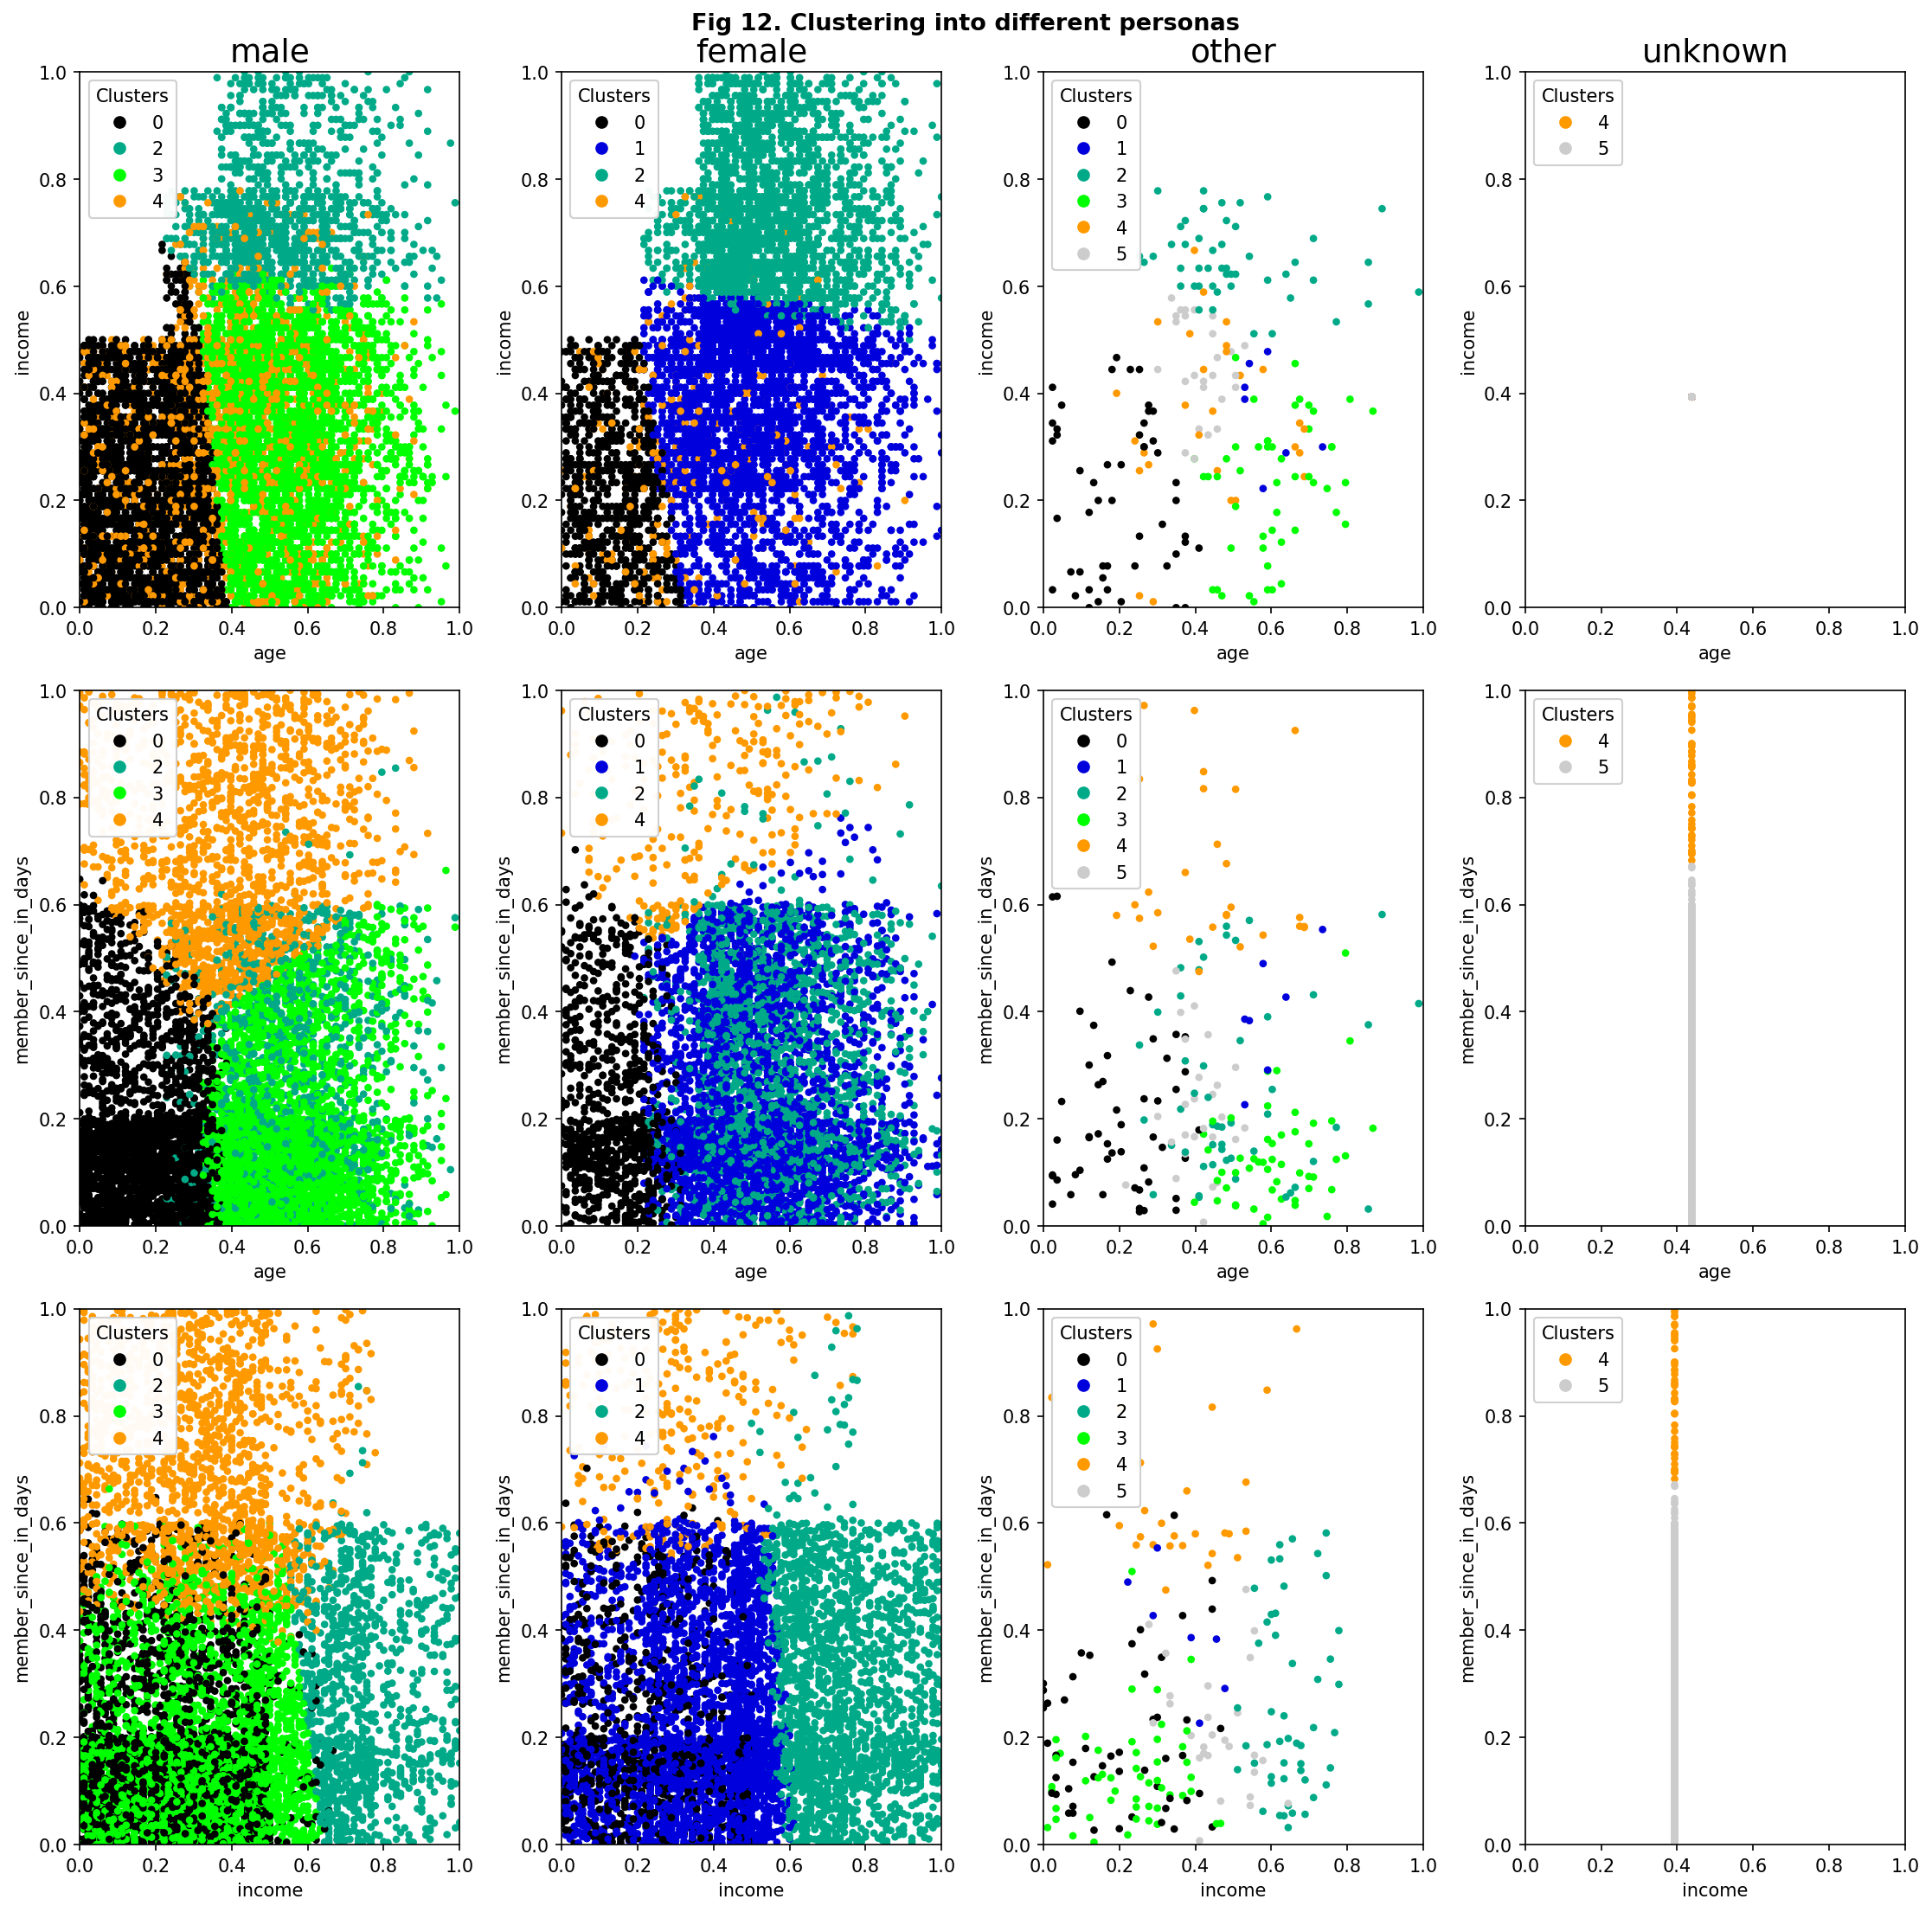

In [24]:
from itertools import cycle, islice, combinations

plot_num = 1
num_plots = 6

genders = ["male", "female", "other", "unknown"]
attributes = ["age", "income", "member_since_in_days"]
attributes_comb = list(combinations(attributes, 2))
attributes_dict = {"age": 0, "income": 1, "member_since_in_days": 2}

fig = plt.figure(figsize=(15, 15))

for i_attribute, attribute in enumerate(attributes_comb):
    for i_gender, gender in enumerate(genders):

        scaler = MinMaxScaler()
        scaled_clustered_profile = clustered_profile.copy()
        scaled_clustered_profile[attributes] = scaler.fit_transform(
            clustered_profile[attributes]
        )

        is_male = clustered_profile["gender_M"] == 1
        is_female = clustered_profile["gender_F"] == 1
        is_other = clustered_profile["gender_O"] == 1

        if gender == "male":
            filtered_profile = scaled_clustered_profile[is_male]
        elif gender == "female":
            filtered_profile = scaled_clustered_profile[is_female]
        elif gender == "other":
            filtered_profile = scaled_clustered_profile[is_other]
        elif gender == "unknown":
            filtered_profile = scaled_clustered_profile[
                ~is_male & ~is_female & ~is_other
            ]

        X = filtered_profile[columns_for_clustering]
        y_pred = filtered_profile["cluster"]

        ax = plt.subplot(len(attributes), len(genders), plot_num)

        if i_attribute == 0:
            plt.title(gender, size=18)

        color_label = y_pred.to_numpy().astype(np.float32)
        scatter = ax.scatter(
            X[attribute[0]],
            X[attribute[1]],
            s=10,
            c=color_label,
            label=color_label,
            vmin=clustered_profile.cluster.min(),
            vmax=clustered_profile.cluster.max(),
            cmap="nipy_spectral",
        )

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel(attribute[0])
        plt.ylabel(attribute[1])

        # produce a legend with the unique colors from the scatter
        ax.legend(fontsize="small")
        legend1 = ax.legend(
            *scatter.legend_elements(), loc="upper left", title="Clusters"
        )
        ax.add_artist(legend1)

        plot_num += 1


plt.suptitle(
    f"Fig {num_fig}. Clustering into different personas", fontsize=13, weight="bold"
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_clustering_persona")
num_fig = num_fig + 1

As a result, we saw that 6 would be the optimal number of cluster. Hence, we are now ready to scatter plot the cluserters. Note that we plot the following data for each gender (male, female, other, unknown):
 - income over age
 - member_since_in_days over age
 - member_since_in_days over income
 
 
As a result, we have revealed the following clusters which can be shortly described as:
 
 - Cluster 0: Low income, low age, new member
 - Cluster 1: Female, low income, high age, new member
 - Cluster 2, High income, high age, new member
 - Cluster 3: Male, low income, high age, new member
 - Cluster 4: Old members
 - Cluster 5: Members with unknown data
 
 In the following we are not ready to merge the three preprocessed data sets (portfolio, profile, transcript) into a single one. We merge transcript and profile based on the `customer_id`. Then, we merge the portfolio into this based on `offer_id`.

In [25]:
def merge_data_sets(df_portfolio, df_profile, df_transcript):
    """
    input:
        df_portfolio: cleaned portfolio data set
        df_profile: cleaned profile data set
        df_transcript: cleaned transcript data set
    output:
        df_all_data: merged data set consisting of portfolio, profile, and transcript
    """
    df_all_data = df_profile
    df_all_data = df_all_data.merge(right=df_transcript, how="left", on="customer_id")
    df_all_data = df_all_data.merge(right=df_portfolio, how="left", on="offer_id")

    df_all_data = df_all_data.fillna(0)

    return df_all_data


all_data = merge_data_sets(portfolio_cleaned, clustered_profile, transcript_cleaned)
all_data

age                       customer_id        income  \
0       54.393524  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
1       54.393524  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
2       54.393524  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
3       54.393524  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
4       54.393524  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
...           ...                               ...           ...   
306529  62.000000  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
306530  62.000000  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
306531  62.000000  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
306532  62.000000  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
306533  62.000000  e4052622e5ba45a8b96b59aba68cf068  82000.000000   

        member_since_in_days  missing_data  gender_F  gender_M  gender_O  \
0                        529             1         0         0         0   
1                        529             1         0         0         0   
2                        529             1         0         0         0   
3                        529             1         0         0         0   
4                        529             1         0         0         0   
...                      ...           ...       ...       ...       ...   
306529                   369             0         1         0         0   
306530                   369             0         1         0         0   
306531                   369             0         1         0         0   
306532                   369             0         1         0         0   
306533                   369             0         1         0         0   

        cluster  time  event_offer_completed  event_offer_received  \
0             5   168                      0                     1   
1             5   216                      0                     0   
2             5   336                      0                     1   
3             5   348                      0                     0   
4             5   360                      0                     0   
...         ...   ...                    ...                   ...   
306529        2   480                      1                     0   
306530        2   486                      0                     0   
306531        2   546                      0                     0   
306532        2   576                      0                     1   
306533        2   690                      0                     0   

        event_offer_viewed  event_transaction  amount  \
0                        0                  0    0.00   
1                        1                  0    0.00   
2                        0                  0    0.00   
3                        1                  0    0.00   
4                        0                  1    0.35   
...                    ...                ...     ...   
306529                   0                  0    0.00   
306530                   0                  1   19.47   
306531                   1                  0    0.00   
306532                   0                  0    0.00   
306533                   0                  1   24.71   

                                offer_id  transcript_reward  portfolio_reward  \
0       2906b810c7d4411798c6938adc9daaa5                  0               2.0   
1       2906b810c7d4411798c6938adc9daaa5                  0               2.0   
2       0b1e1539f2cc45b7b9fa7c272da2e1d7                  0               5.0   
3       0b1e1539f2cc45b7b9fa7c272da2e1d7                  0               5.0   
4                                      0                  0               0.0   
...                                  ...                ...               ...   
306529  f19421c1d4aa40978ebb69ca19b0e20d                  5               5.0   
306530                                 0                  0               0.0   
306531  f19421c1d

With the merge data set, we can now have a look at the events with respect to the offer type. The common sequence for the event offers is as follows: received -> viewed -> completed. From the data below we can clearly see that both discount and bogo were received equally. When it comes to vieweing, the bogo was viewed more often, but in the end discount was used more often by the customer.

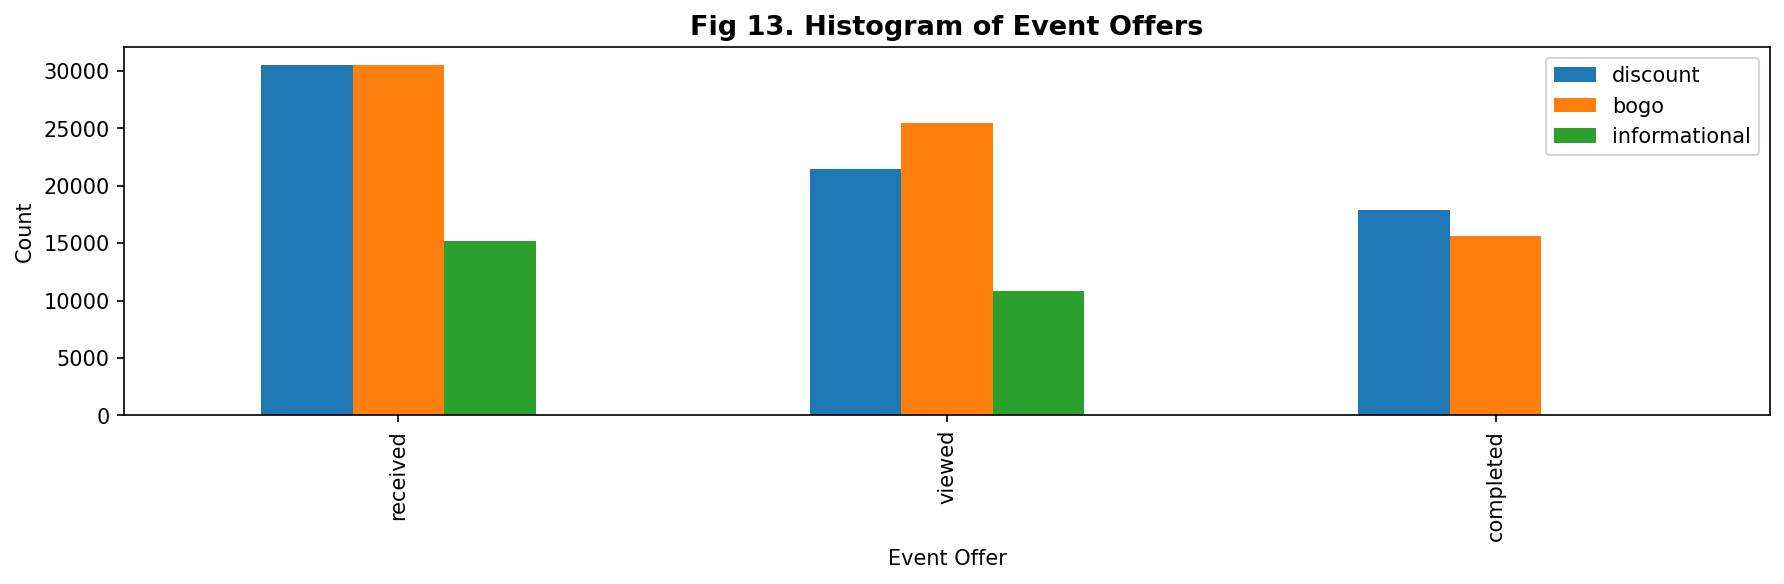

In [26]:
ax = pd.concat(
    [
        all_data[all_data["event_offer_received"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
        all_data[all_data["event_offer_viewed"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
        all_data[all_data["event_offer_completed"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
    ],
    axis=1,
    keys=["discount", "bogo", "informational"],
).T.plot(kind="bar", figsize=(12, 4), label=["discount", "bogo", "informational"])

ax.set_xticklabels(["received", "viewed", "completed"])
ax.set_xlabel("Event Offer")
ax.set_ylabel("Count")
ax.legend(["discount", "bogo", "informational"])

ax.set_title(f"Fig {num_fig}. Histogram of Event Offers", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_event_offers")
num_fig = num_fig + 1

From a different perspective we can look at the offer type and inspect event ofers from this. We can see that for each offerr type the count descreases from received to viewed which is clearly expected. We can also inspect that for discount offers the decrease is much larger for the received ones. For the bogo offer type the most strong descrease in the number of events is from viewed to completed.

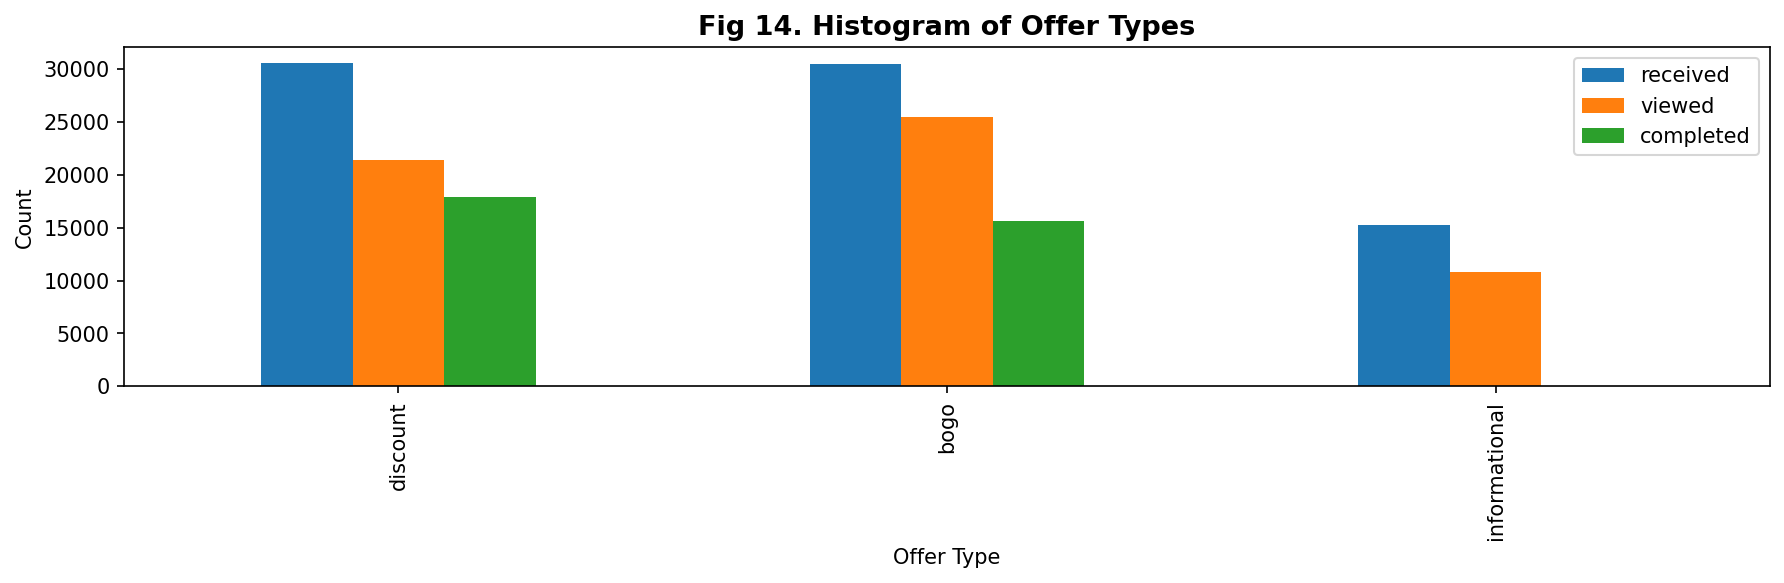

In [27]:
ax = pd.concat(
    [
        all_data[all_data["event_offer_received"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
        all_data[all_data["event_offer_viewed"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
        all_data[all_data["event_offer_completed"] == 1][
            ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
        ].sum(),
    ],
    axis=1,
    keys=["discount", "bogo", "informational"],
).plot(kind="bar", figsize=(12, 4), label=["discount", "bogo", "informational"])
ax.set_xlabel("Offer Type")
ax.set_ylabel("Count")
ax.set_xticklabels(["discount", "bogo", "informational"])
ax.legend(["received", "viewed", "completed"])

ax.set_title(f"Fig {num_fig}. Histogram of Offer Types", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_offer_types")
num_fig = num_fig + 1

We now do the same for our cluster. Here, three things are noteworthy for the reader:

- Cluster 2 is really responsive to offers - not matter if the offer type is discount or bogo.
- Cluster 0, 3, 5 are not really responsive to offers.
- None of the clusters is more responsive to bogo thatn to discount.

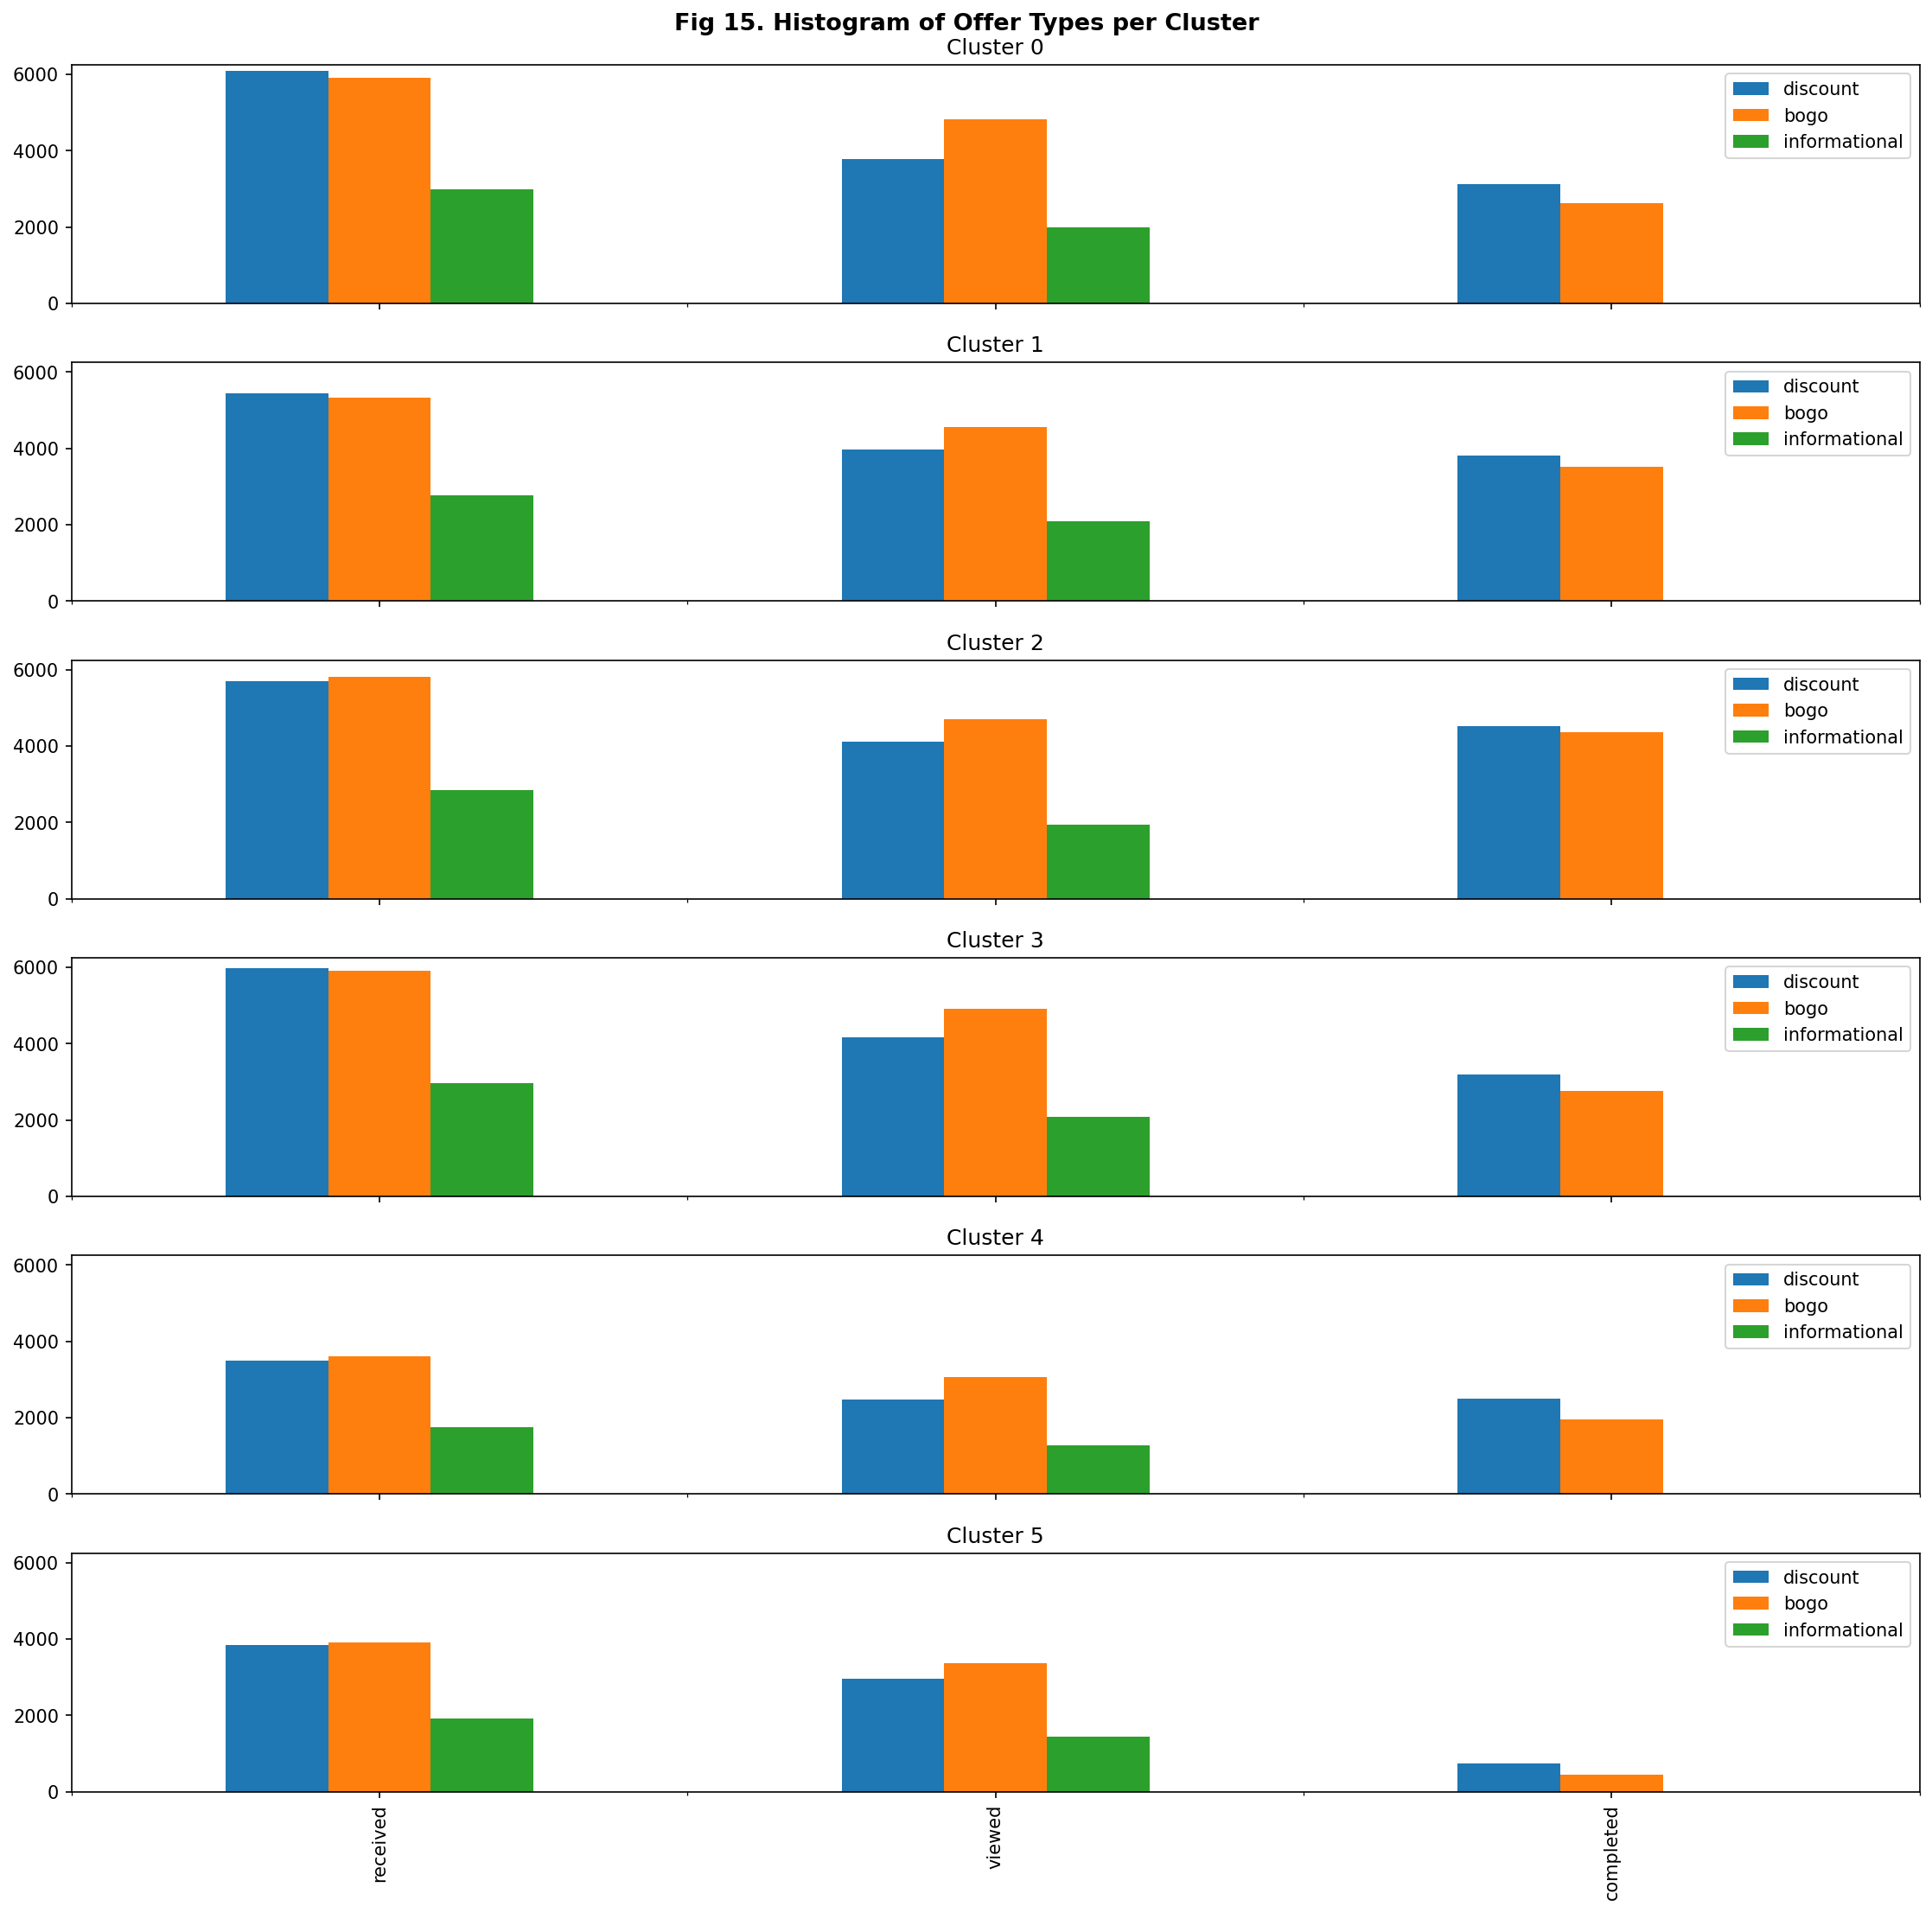

In [28]:
clusters = list(all_data.cluster.sort_values().unique())

fig, axes = plt.subplots(nrows=len(clusters), ncols=1, sharex=True)

for i_cluster, cluster in enumerate(clusters):
    axes[i_cluster].set_xlim(0, 6000)
    ax = pd.concat(
        [
            all_data[
                (all_data["event_offer_received"] == 1)
                & (all_data["cluster"] == cluster)
            ][
                ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
            ].sum(),
            all_data[
                (all_data["event_offer_viewed"] == 1) & (all_data["cluster"] == cluster)
            ][
                ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
            ].sum(),
            all_data[
                (all_data["event_offer_completed"] == 1)
                & (all_data["cluster"] == cluster)
            ][
                ["offer_type_discount", "offer_type_bogo", "offer_type_informational"]
            ].sum(),
        ],
        axis=1,
        keys=["discount", "bogo", "informational"],
    ).T.plot(
        ax=axes[i_cluster],
        kind="bar",
        figsize=(15, 15),
        label=["discount", "bogo", "informational"],
        title=f"Cluster {cluster}",
        ylim=(0, 6250),
    )
    ax.set_xticklabels(["", "", ""])
    ax.legend(["discount", "bogo", "informational"])
ax.set_xticklabels(["received", "viewed", "completed"])


plt.suptitle(
    f"Fig {num_fig}. Histogram of Offer Types per Cluster", fontsize=13, weight="bold"
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_offer_types")
num_fig = num_fig + 1

In [29]:
aggregation_functions = {
    "age": "max",
    "customer_id": "max",
    "income": "max",
    "member_since_in_days": "max",
    "missing_data": "max",
    "gender_F": "max",
    "gender_M": "max",
    "gender_O": "max",
    "cluster": "max",
    "time": "max",
    "event_offer_completed": "max",
    "event_offer_received": "max",
    "event_offer_viewed": "max",
    "event_transaction": "max",
    "amount": "max",
    "offer_id": lambda x: list(x),
    "portfolio_reward": "max",
    "transcript_reward": "max",
    "difficulty": "max",
    "duration": "max",
    "channel_email": "max",
    "channel_mobile": "max",
    "channel_social": "max",
    "channel_web": "max",
    "offer_type_bogo": "max",
    "offer_type_discount": "max",
    "offer_type_informational": "max",
}
# reduced_data.offer_id=reduced_data.offer_id.replace(0, np.nan)
transaction_merged_all_data = (
    all_data.groupby(["customer_id", "time"])
    .aggregate(aggregation_functions)
    .reset_index(drop=True)
)

is_event_offer_completed = transaction_merged_all_data["event_offer_completed"] == 1
is_event_transaction = transaction_merged_all_data["event_transaction"] == 1

all_transaction_with_offer = transaction_merged_all_data[
    is_event_transaction & is_event_offer_completed
]
all_transaction_without_offer = transaction_merged_all_data[
    is_event_transaction & ~is_event_offer_completed
]

In [30]:
from scipy import stats

all_transaction_without_offer = all_transaction_without_offer[
    (np.abs(stats.zscore(all_transaction_without_offer["amount"])) < 3)
]
all_transaction_with_offer = all_transaction_with_offer[
    (np.abs(stats.zscore(all_transaction_with_offer["amount"])) < 3)
]

In the following we plot the histogram for the amount of money spent. We do this once for the group that didn't receive any offer and once for the group that used an offer before buying. We can see that with offer the amount of money spent is larger. Wihout offer the people tend to spend less money which can be seen by the large properotion between 0 and 10. For the amount spent with offer the average is somewhere around 15 which is clearly more than without.

(0.0, 11000.0)

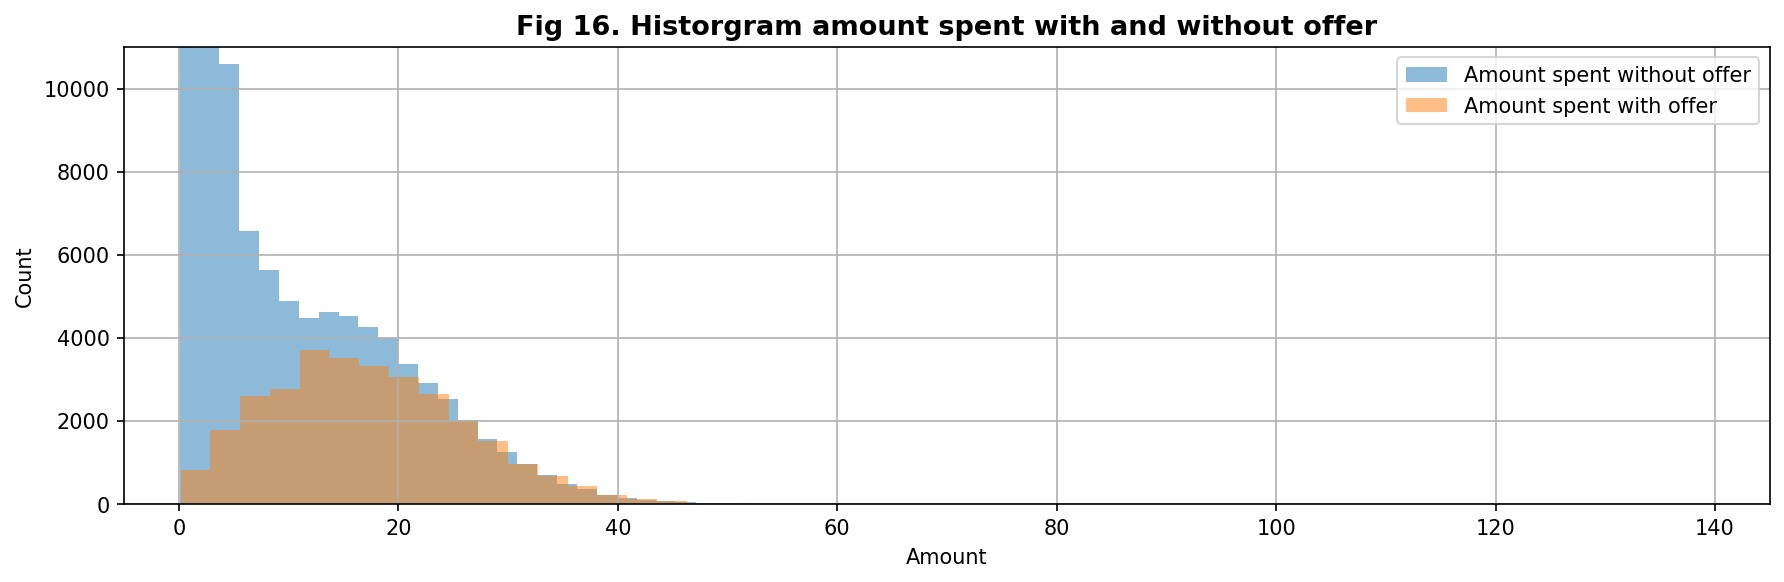

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))

all_transaction_without_offer.hist(column="amount", bins=50, alpha=0.5, ax=ax)
all_transaction_with_offer.hist(column="amount", bins=50, ax=ax, alpha=0.5)

ax.legend(["Amount spent without offer", "Amount spent with offer"])
ax.set_title("Distribution of Amount")
ax.set_ylabel("Count")
ax.set_xlabel("Amount")
ax.set_xlim([-5, 145])


ax.set_title(
    f"Fig {num_fig}. Historgram amount spent with and without offer",
    fontsize=13,
    weight="bold",
)
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_amount_spent_offer")
num_fig = num_fig + 1
ax.set_ylim([0, 11000])

We do the same for each group of cluster as we can see in the following chart. We can summarize the results as follows:

For cluster 1 and 2 the amount spent are almost the same - no matter if they are using an offer.
For cluster 0, 3, 4, 5 the amount spend increases in average if we compare the amount spent with and wihtout offer.

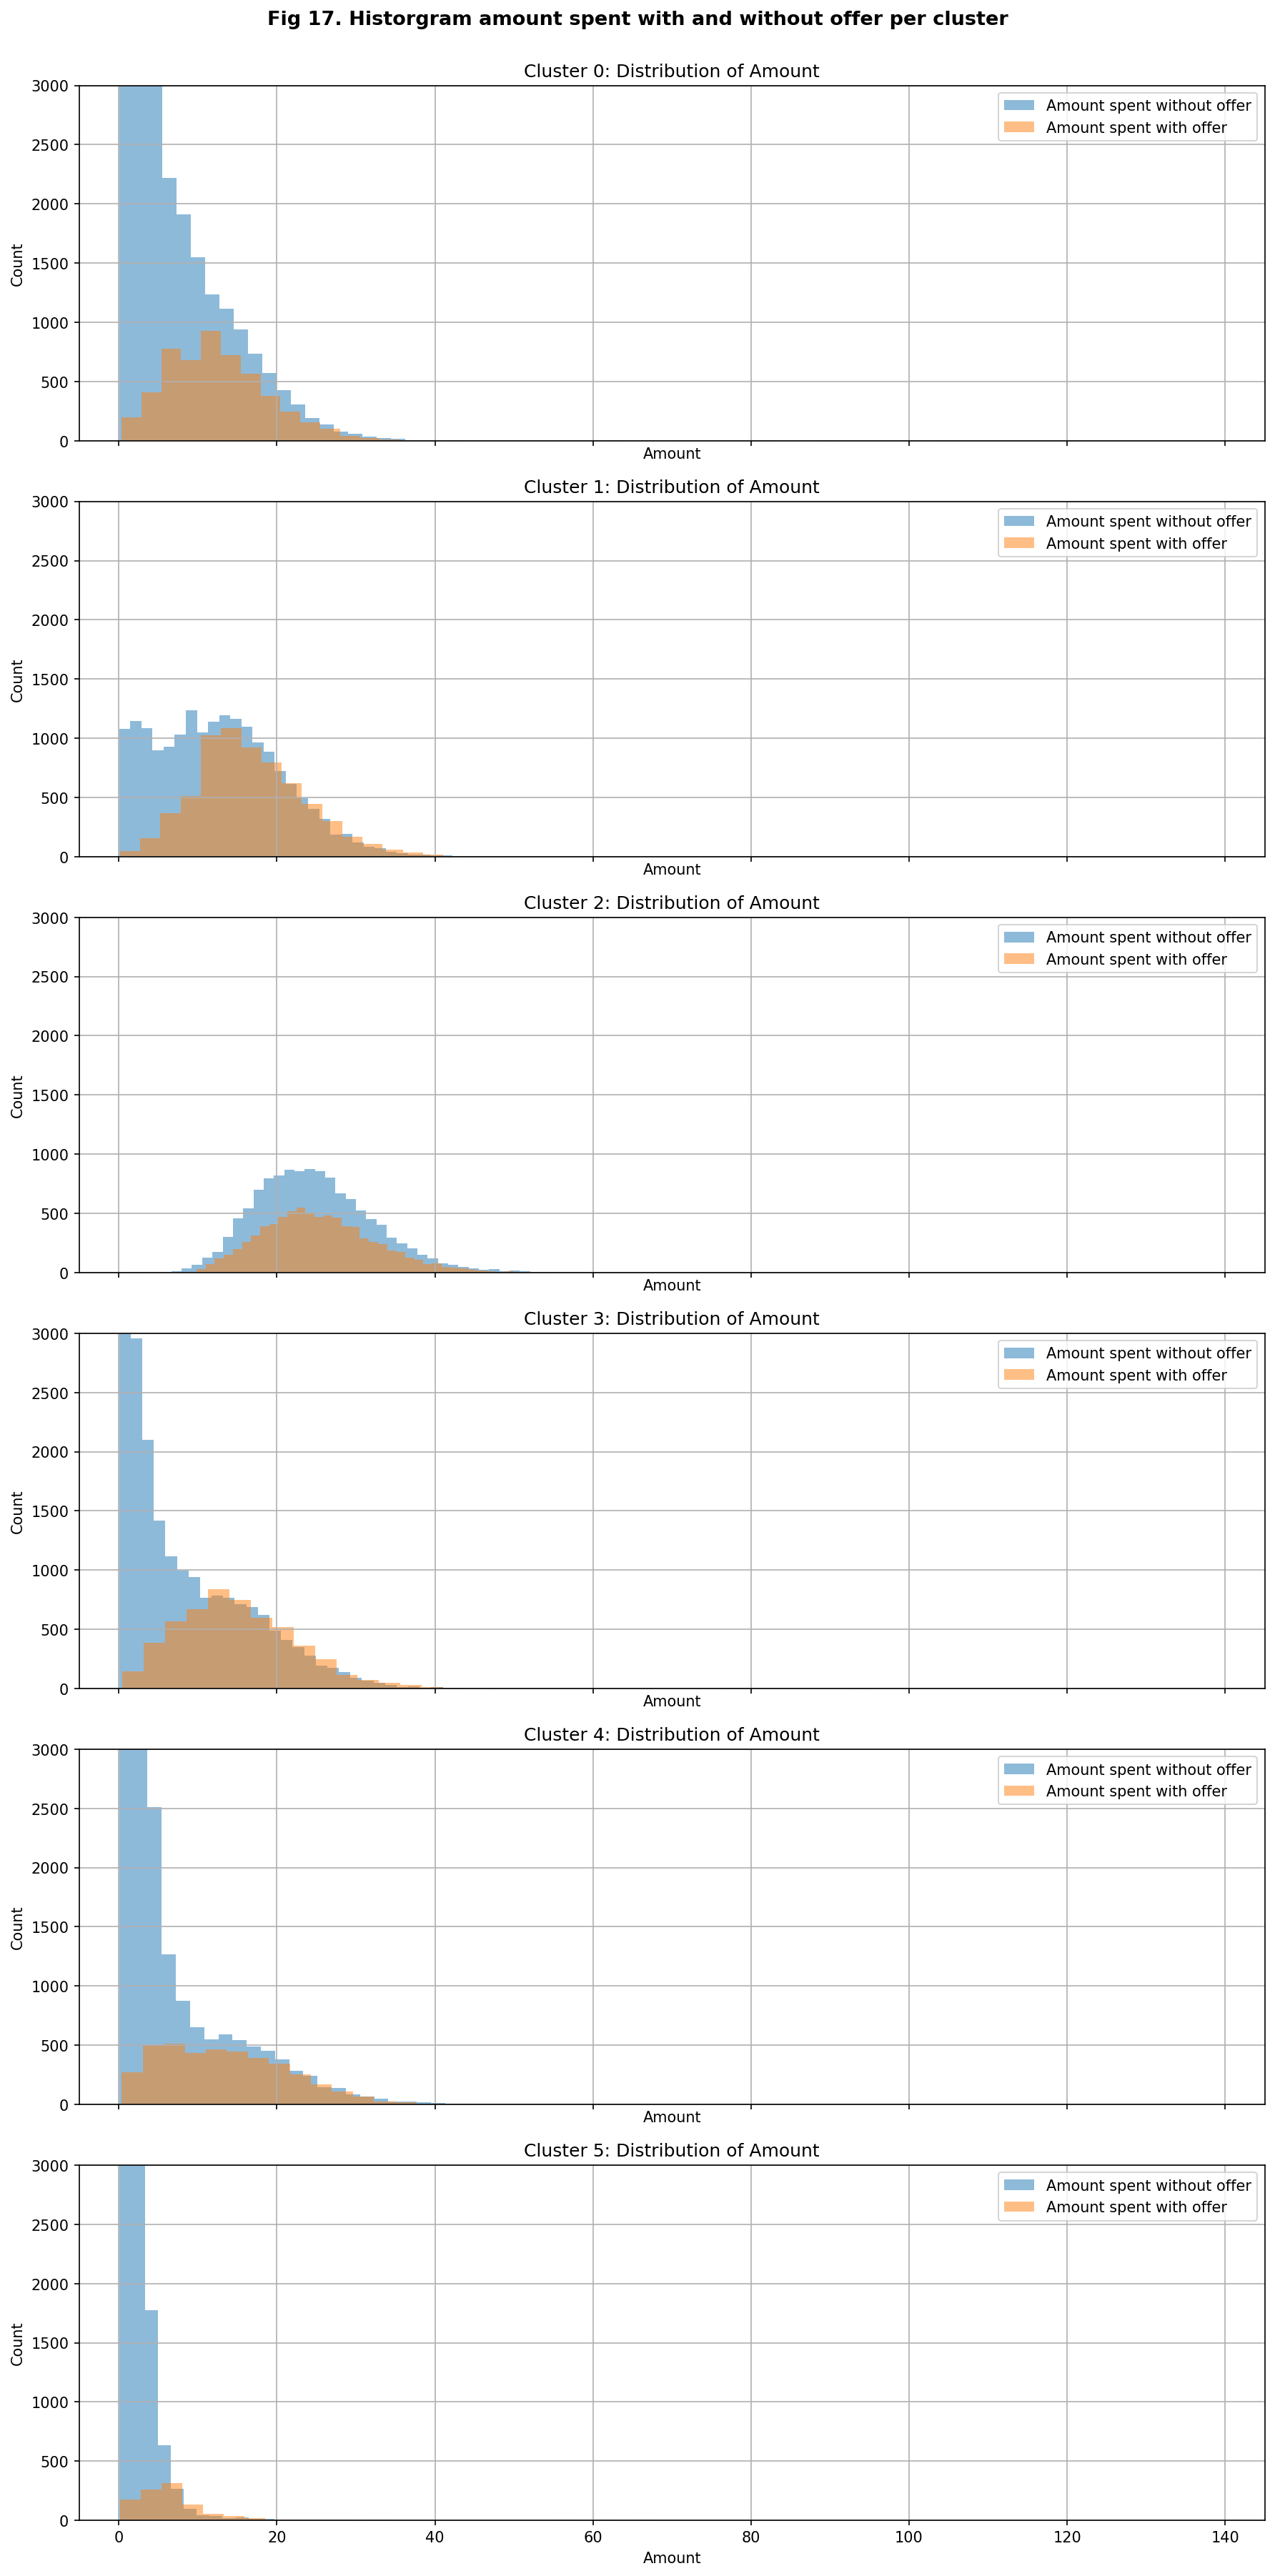

In [32]:
clusters = list(all_data.cluster.sort_values().unique())


fig, axes = plt.subplots(nrows=len(clusters), ncols=1, sharex=True, figsize=(12, 6 * 4))
fig.subplots_adjust(top=0.8)
fig.suptitle(
    f"Fig {num_fig}. Historgram amount spent with and without offer per cluster",
    y=1,
    fontsize=13,
    weight="bold",
)

for i_cluster, cluster in enumerate(clusters):

    all_transaction_without_offer[
        all_transaction_without_offer.cluster == cluster
    ].hist(column="amount", bins=50, alpha=0.5, ax=axes[i_cluster])
    all_transaction_with_offer[all_transaction_with_offer.cluster == cluster].hist(
        column="amount", bins=50, alpha=0.5, ax=axes[i_cluster]
    )

    axes[i_cluster].legend(["Amount spent without offer", "Amount spent with offer"])
    axes[i_cluster].set_title(f"Cluster {cluster}: Distribution of Amount")
    axes[i_cluster].set_ylabel("Count")
    axes[i_cluster].set_xlabel("Amount")
    axes[i_cluster].set_xlim([-5, 145])
    axes[i_cluster].set_ylim([0, 3000])


fig.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_histogram_amount_spent_offer")
num_fig = num_fig + 1

In [33]:
all_data.columns

Index(['age', 'customer_id', 'income', 'member_since_in_days', 'missing_data',
       'gender_F', 'gender_M', 'gender_O', 'cluster', 'time',
       'event_offer_completed', 'event_offer_received', 'event_offer_viewed',
       'event_transaction', 'amount', 'offer_id', 'transcript_reward',
       'portfolio_reward', 'difficulty', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational'],
      dtype='object')

We are now ready to model the correlation between the different features. We are dropping the event_offers, the amount, the transcript reward, and some events (received, viewed, transaction). 

We can see that the age relates to income. Note also that females tend to be older and have a higher income since gender_F has a positive coefficient with both income and age. All the data from the portfolio are also more correlated.

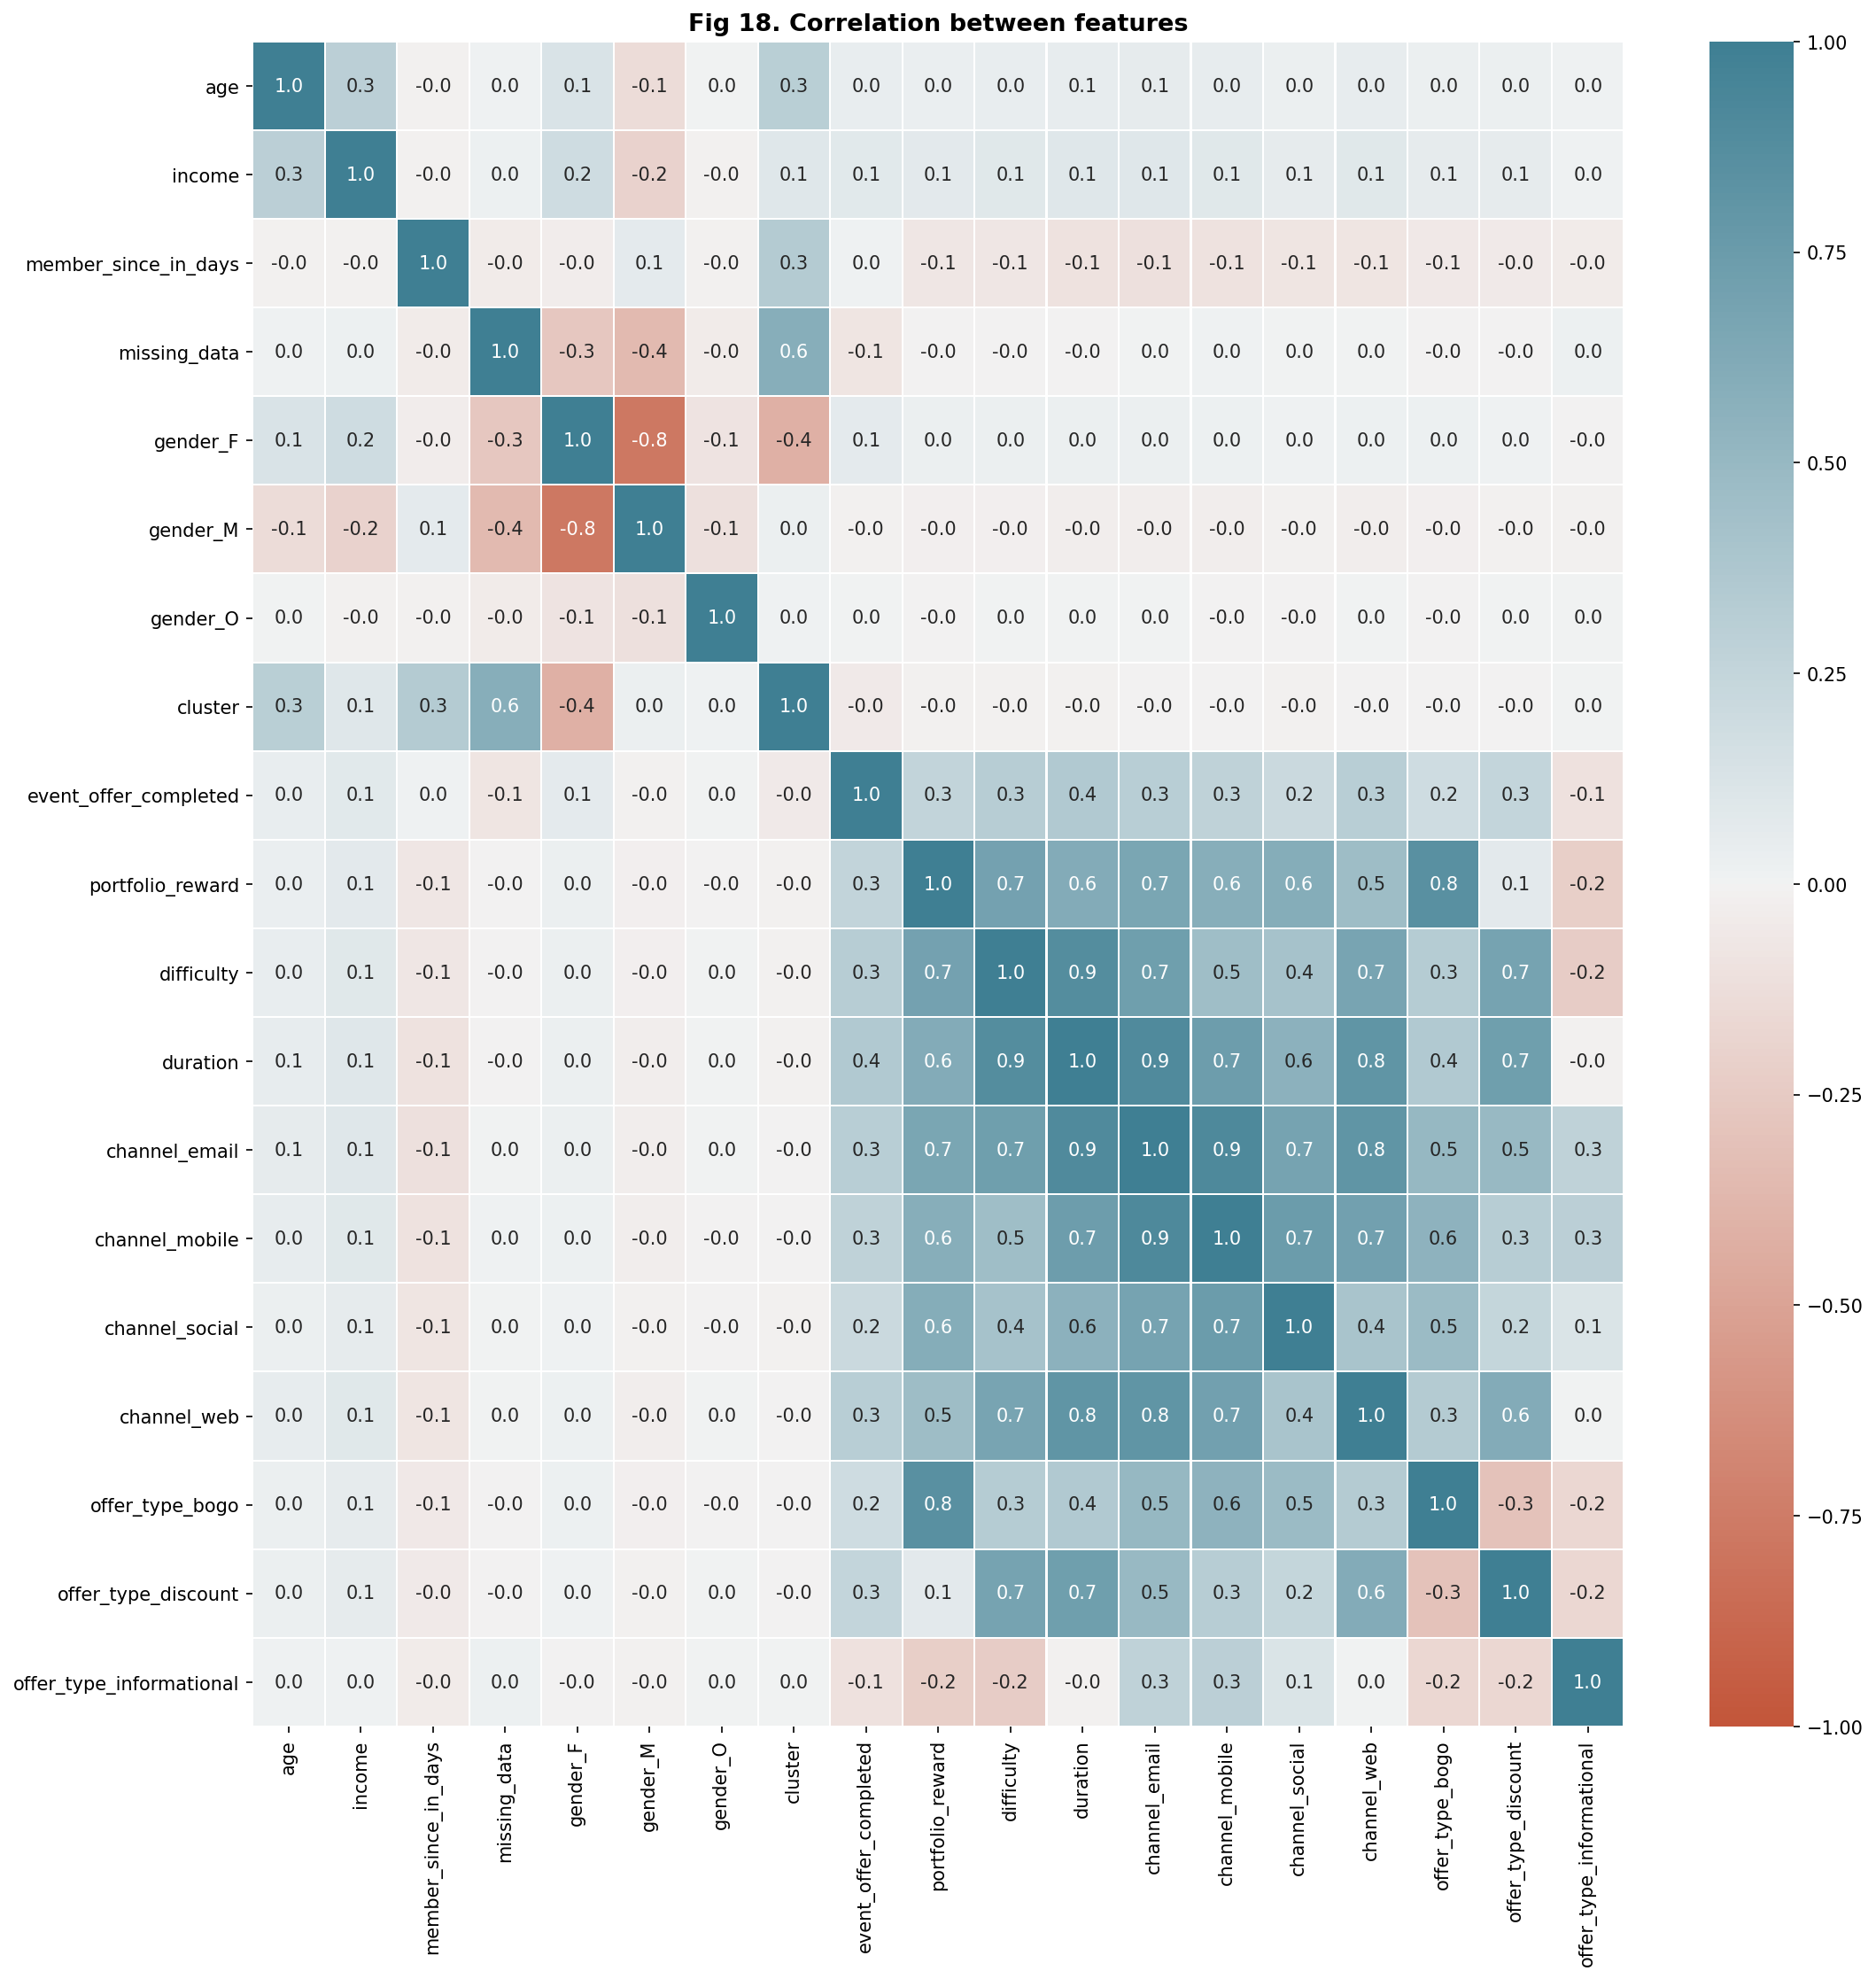

In [34]:
import seaborn as sns

cols_to_drop = [
    "customer_id",
    "time",
    "event_offer_received",
    "event_offer_viewed",
    "event_transaction",
    "amount",
    "transcript_reward",
]
all_data_for_ml = all_data.drop(columns=cols_to_drop)

fig, ax = plt.subplots(figsize=(15, 15))  # Sample figsize in inches
sns.heatmap(
    all_data_for_ml.corr(),
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, as_cmap=True),
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    ax=ax,
)

ax.set_title(f"Fig {num_fig}. Correlation between features", fontsize=13, weight="bold")
plt.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_correlation_between_features")
num_fig = num_fig + 1

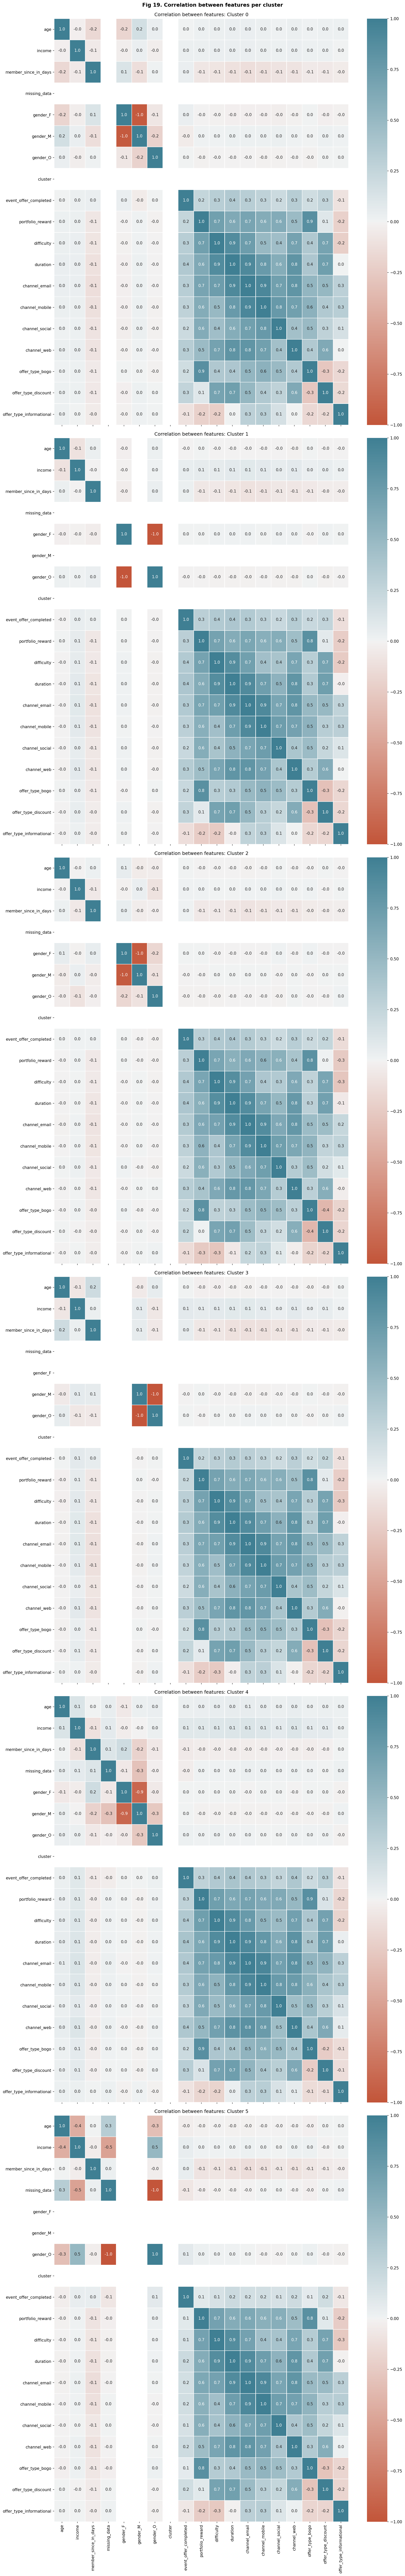

In [35]:
clusters = list(all_data_for_ml.cluster.sort_values().unique())

fig, axes = plt.subplots(
    nrows=len(clusters), ncols=1, sharex=True, figsize=(15, 15 * 6)
)
fig.subplots_adjust(top=0.8)

for i_cluster, cluster in enumerate(clusters):

    sns.heatmap(
        all_data_for_ml[all_data_for_ml.cluster == cluster].corr(),
        vmin=-1,
        vmax=1,
        cmap=sns.diverging_palette(20, 220, as_cmap=True),
        annot=True,
        fmt=".1f",
        linewidths=0.5,
        ax=axes[i_cluster],
    )

    axes[i_cluster].set_title(f"Correlation between features: Cluster {cluster}")

fig.tight_layout()
plt.gcf().set_dpi(150)
plt.savefig(f"image/{num_fig}_correlation_between_featuers_for_clusters")
plt.suptitle(
    f"Fig {num_fig}. Correlation between features per cluster",
    y=1.002,
    fontsize=13,
    weight="bold",
)
num_fig = num_fig + 1

#### Predicting if customer takes offer <a class="anchor" id="chapter_4_2"></a>

Our second goal is now to predict or better said classify of a customers is willing to take an offer. We use the `event_offer_completed` column as the target and all the remaining columns as features. Then we split this set into training and testings data.

We then employ a classification algorithm here as follows.

##### Model implementation <a class="anchor" id="chapter_4_2_1"></a>

In order to cluster the customers into groups, we first transform the customer id with a column transformer (https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) with an ordinal encoder. This encodes the uuid from the customer into a single numerical value that can be used in the algorithm. Afterwards, we scale the data with a Standard scaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) so that it can be used with the classifier. As a classifier we use the RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
With all these estimators we create a pipeline whose hyper parameter are tuned with Grid Search CV. We use the following parameters to tune the pipeline 

- n_estimators: the number of estimators
- bootstrap: if bootstrap samples are used when building trees
- criterion: quality of a split: “gini” for the Gini impurity and “entropy” for the information gain

In [36]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance


def training(X, y):
    """
    input:
        X: The preprocessed listings.
        y: Split from original listings and serve as target in training process.
    output:
        pipeline: optimal ML model given by GridSearchCV
    """

    # Define a pipeline to search for the best combination
    column_trans = make_column_transformer(
        (OrdinalEncoder(), ["offer_id"]), remainder="passthrough"
    )
    scaler = StandardScaler()
    regressor = RandomForestClassifier()
    pipe = make_pipeline(column_trans, scaler, regressor)

    # Grid Search to find Best Parameter
    param_grid = {
        "randomforestclassifier__n_estimators": [100, 200, 300],
        "randomforestclassifier__bootstrap": [True, False],
        "randomforestclassifier__random_state": [42],
        "randomforestclassifier__criterion": ["gini", "entropy"],
    }

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        n_jobs=-1,
        cv=5,
        scoring="accuracy",
        return_train_score=True,
    )

    grid_search.fit(X, y)

    pipeline = grid_search.best_estimator_
    return pipeline


all_data_for_ml.offer_id = all_data_for_ml.offer_id.replace(0, None)
y = all_data_for_ml["event_offer_completed"]
X = all_data_for_ml.drop(columns=["event_offer_completed", "cluster"])
# Split the preprocessed dataset into train/test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
model = training(X_train, y_train)

Training set has 245227 samples.
Testing set has 61307 samples.


##### Evaluation and validation <a class="anchor" id="chapter_4_2_2"></a>

We employ the accuracy score to assess the result. This is quite useful here as we noted before. In addition, we rank the features which are most relevant for predicting whether a customer is willing to take the offer. Here, we employ the feature importances for the forest.

More information on accuracy score analysis can be found at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html. The creation of the feature importance is inspired by https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importance-based-on-mean-decrease-in-impurity

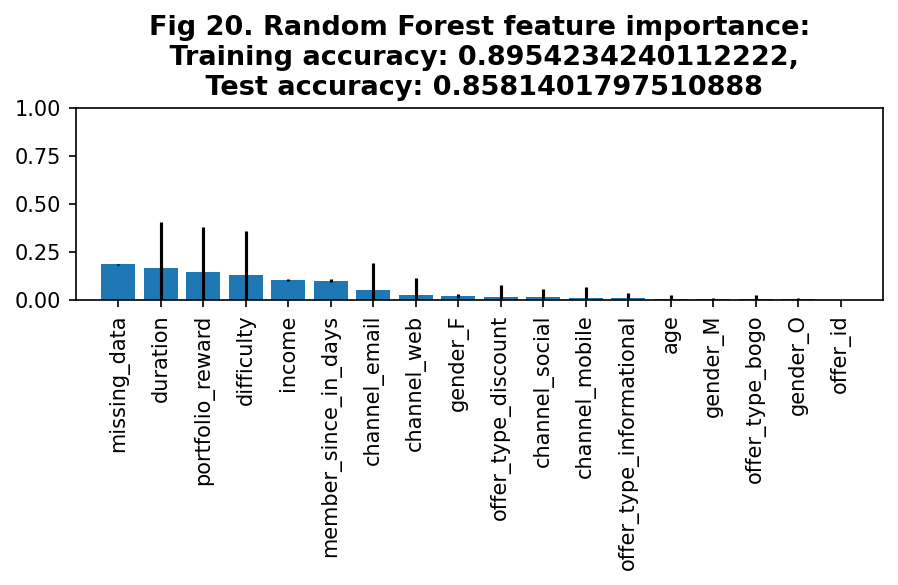

In [37]:
from sklearn.metrics import accuracy_score


def validate_classifier(model, X_train, X_test, y_train, y_test, ax, group=None):
    """
    input:
        model: the fitted ML model for predicting if someone takes the BOGO/discount
        X_train: the training data for the preprocessed data set
        X_test: the test data for the preprocessed data set
        y_train: Split from original dataframe and serve as target in training process.
        y_test: Split from original dataframe and serve as test in training process.
        ax: matplotlib axis onto which the important features should be drawn onto
        group: cluster number
    output:
        None
    """
    # from https://scikit-learn.org/stable/modules/cross_validation.html
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))

    importance_vals = model["randomforestclassifier"].feature_importances_
    std = np.std(
        [
            tree.feature_importances_
            for tree in model["randomforestclassifier"].estimators_
        ],
        axis=0,
    )
    indices = np.argsort(importance_vals)[::-1]

    # Plot the feature importances of the forest

    if group is None:
        ax.set_title(
            f"Fig {num_fig}. Random Forest feature importance:\n Training accuracy: {train_accuracy},\n Test accuracy: {test_accuracy}",
            fontsize=13,
            weight="bold",
        )
    else:
        ax.set_title(
            f"Cluster {group}:\n Random Forest feature importance:\n Training accuracy: {train_accuracy},\n Test accuracy: {test_accuracy}",
        )

    ax.bar(
        range(X.shape[1]), importance_vals[indices], yerr=std[indices], align="center"
    )
    ax.set_xticks(range(X.shape[1]))
    ax.set_xticklabels(X_train.columns[indices].to_list(), rotation=90)
    ax.set_xlim([-1, X.shape[1]])
    ax.set_ylim([0, 1])


fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)
validate_classifier(model, X_train, X_test, y_train, y_test, ax)

plt.tight_layout()

plt.savefig(f"image/{num_fig}_feature_importance")
num_fig = num_fig + 1

For the overall data, we can see that the most important feature is the augmented one called `missing_data`. This is followed by `portfolio_reward`, `difficulty`, and `duration`. In particular, the gender and the channels have a minor influence on the decision. 

Cluster 0
Training set has 49230 samples.
Testing set has 12308 samples.
Cluster 1
Training set has 45194 samples.
Testing set has 11299 samples.
Cluster 2
Training set has 43485 samples.
Testing set has 10872 samples.
Cluster 3
Training set has 45431 samples.
Testing set has 11358 samples.
Cluster 4
Training set has 35099 samples.
Testing set has 8775 samples.
Cluster 5
Training set has 26786 samples.
Testing set has 6697 samples.


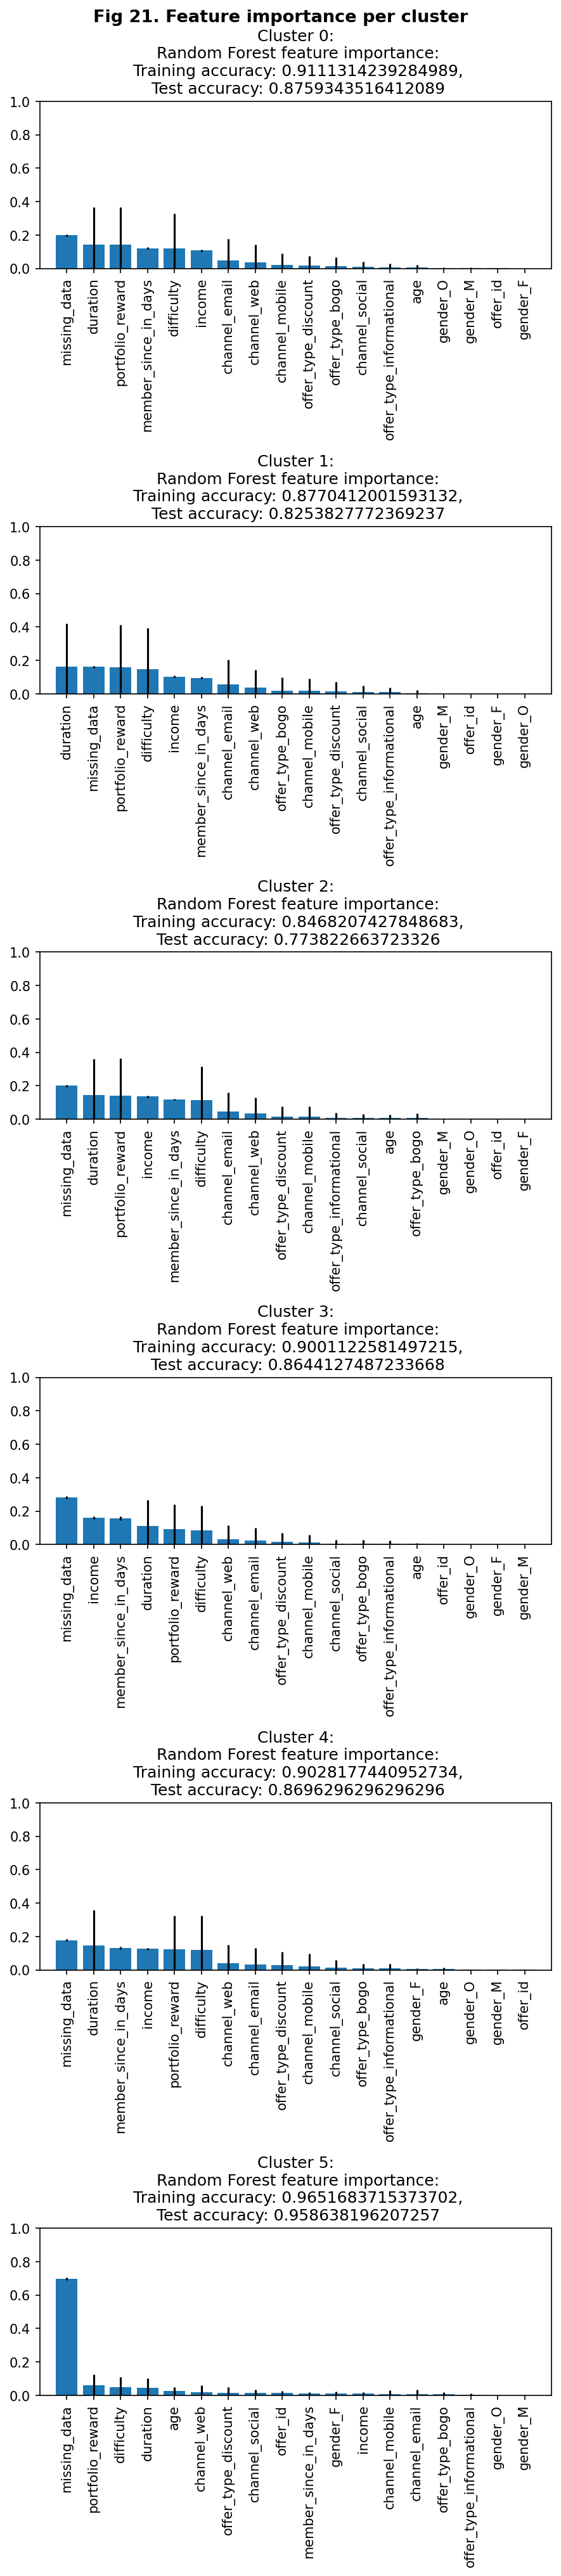

In [38]:
clusters = list(all_data_for_ml.cluster.sort_values().unique())

fig = plt.figure(figsize=(6, len(clusters) * 4.5), dpi=150)

for i_cluster, cluster in enumerate(clusters):
    print("==============")
    print(f"Cluster {cluster}")

    y = all_data_for_ml[all_data_for_ml.cluster == cluster]["event_offer_completed"]
    X = all_data_for_ml[all_data_for_ml.cluster == cluster].drop(
        columns=["event_offer_completed", "cluster"]
    )
    # Split the preprocessed dataset into train/test dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))

    ax = fig.add_subplot(len(clusters), 1, i_cluster + 1)
    model = training(X_train, y_train)
    validate_classifier(model, X_train, X_test, y_train, y_test, ax, cluster)
    print("==============")

plt.tight_layout()
plt.gcf().set_dpi(150)
plt.suptitle(
    f"Fig {num_fig}. Feature importance per cluster",
    y=1.002,
    fontsize=13,
    weight="bold",
)
plt.savefig(f"image/{num_fig}_feature_importance_for_clusters")
num_fig = num_fig + 1

We can see that the accuracy of the test data is somewhere between 0.79 and 0.95, where the model can be best created for cluster 5 (the one with missing data) and the least for cluster 2.

The top 3 features for the clusters are the following:
- cluster 0: missing_data, member_since_in_days, income
- cluster 1: missing_data, income, member_since_in_days
- cluster 2: missing_data, income, member_since_in_days
- cluster 3: missing_data, income,  member_since_in_days
- cluster 4: missing_data, member_since_in_days, income
- cluster 5: missing_data, portfolio_reward, difficulty

### Conclusion <a class="anchor" id="chapter5"></a>

The overall accuracy score of 0.95 on the test data set is quite high. This means that we have a good machine learning model for the predicting whether a customer takes an offer or not. Desprite this good result, we are concerned that the result mostly depends on the newly created feature `missing_data`. Initially, we would have expected that the classification is more strongly coupled to the demographic data such as age, income, or gender.

The approach we chose is general and can be easily adapted to new methods like new classifiers or pipelines in the future.

#### Reflection <a class="anchor" id="chapter_5_1"></a>

This jupyter notebook is the major output for my Udacity data science nanodegree. In order to finish the nanodegree, the task was to inspect and analyze the Starbucks data provided for this capstone project. In general, I found the capstone project to be very interesting but also rather difficult.

The two most difficult things for me were the following:
- what are the key problems for the data set and how to formulate them
- after obtaining an intermediate result with the clustering algorithm I was uncertain how to continue with the clusters in the next step since the correlations didn't provide any significant difference between the clsuters.


#### Improvement <a class="anchor" id="chapter_5_1"></a>

For future improvement we suggest to employ different classification approaches in order to obtain a better and more accurate prediction. Just like this, we also suggest to create a web app where we can type in the customer details and then send him an offer or not based on the prediction model.